# DEEPMIND ALPHAZERO CHESS

## TODO
- Calculate Advantages in Agent Train Function
- Have training on GPU and inference CPU
- Implement https://www.youtube.com/watch?v=a4VvcmqnkhY
- print(f"INVALID ACTION {action}.\nSELECTING A RANDOM ACTION FROM LEGAL ACTIONS\n{self.legal_actions()}") #### DISABLED FOR VIEWING PRINTS PROPERLY!


## TODO LATER
#### - Get backward possibly loss to train the controller. Might need to save the tensor output like states, values, etc in MCTS
- Create Self play class
- Create Arena class

DEEP MIND OPEN ACCESS PAPER 

https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd

RAY ALPHA ZERO IMPLEMENTATION 

https://github.com/ray-project/ray/tree/master/rllib/contrib/alpha_zero

DUPLICATED MCTS IMPLEMENTATION

https://github.com/suragnair/alpha-zero-general/blob/master/MCTS.py

DISTRIBUTED IMPLEMENTATION

https://github.com/mokemokechicken/reversi-alpha-zero/blob/master/src/reversi_zero/lib/ggf.py

CHESS MOVES

https://www.ichess.net/blog/chess-pieces-moves/

BOARD REPRESENTATIONS

https://medium.com/datadriveninvestor/reconstructing-chess-positions-f195fd5944e

ALPHA ZERO EXPLANATION

https://nikcheerla.github.io/deeplearningschool/2018/01/01/AlphaZero-Explained/

TRANSFORMER NETWORK IMPLEMENTATION

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [1]:
!pip install --user python-chess gym colorama tqdm PyQt5 ray tensorboard

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import chess, gym, pickle, random, torch, math, ray
ray.init()
import chess.svg as svg
import numpy as np
import pandas as pd
from copy import copy, deepcopy
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical
# plt.style.use('ggplot')
from scipy.ndimage.interpolation import shift
from copy import deepcopy
from colorama import init, Fore, Back, Style
from collections import Counter, deque
from tqdm import tqdm, tnrange, notebook
from random import shuffle
import tkinter as tk
from tkinter import simpledialog
from PyQt5.QtSvg import QSvgWidget
from PyQt5.QtWidgets import QApplication, QWidget

from utilities import *
# import constants 
from constants import *
from models.vae import CNN_AE, CNN_VAE, train_ae, train_vae, Conv
from models.mdn import MDN_RNN, loss_function, clip_grad_norm_
from models.controller import Policy_Controller, Value_Controller

# init(convert = True)
# REFERENCES
# Tensorflow implementation for Chess
# https://github.com/saurabhk7/chess-alpha-zero

# Pytorch implementation for Connect4
# https://github.com/plkmo/AlphaZero_Connect4/tree/master/src

2020-08-22 20:39:44,925	INFO resource_spec.py:231 -- Starting Ray with 37.3 GiB memory available for workers and up to 18.66 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-22 20:39:45,359	INFO services.py:1193 -- View the Ray dashboard at localhost:8265


In [3]:
class MCTS():
    """Monte Carlo Tree Search Algorithm geared for Neural Networks"""

    def __init__(self, env, agent, mcts_simulations = 100, max_depth = 100, delta = 0.5):
        self.env = env
        self.agent = agent
        self.cpuct = 1.5    # WARNING BULLSHIT NUMBER!
        self.delta = delta  # value to prevent crash if no edges are visited
        self.mcts_simulations = mcts_simulations
        self.max_depth = max_depth
        
        self.Qsa = {}       # stores Q values for s, a (as defined in the paper)
        self.Nsa = {}       # stores # times edge s, a was visited
        self.Ns = {}        # stores # times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores victory result (1, 0, -1) ended for board s
        self.Vs = {}        # stores legal actions for board s
        self.z = {}         # stores the features of the state
        self.hidden = {}    # stores the hidden states

    def action_probabilities(self, encoded_state, temp = 1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for runs in range(self.mcts_simulations):
#             print(f"{Fore.BLUE}MCTS SIMULATION {runs + 1}{Style.RESET_ALL}")
            self.search(encoded_state, 0)
        
        s = encoded_state
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in legal_actions]
        # counts array represent the number of time each action edge from your current state was traversed
        
        # temprature is 0 representing taking the best action possible (greedy)
        if temp == 0: 
            # bestA: best action number : argmax Returns the indices of the maximum values
            bestA = np.argmax(counts) 
            probs = [0] * len(counts)
            probs[bestA] = 1
            action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
            # returns the definite move(s) with same greedy reward, out of which one move HAS to be played
            return action_probs 
        
#         print(f"{Fore.BLUE}COUNTS {sum(counts)} {counts}{Style.RESET_ALL}")
        
        # Handles frequent draw situation when MCTS fails to explore when the game is over resulting 0 counts causing div 0 error
        if sum(counts) == 0:
            counts = [1 for _ in counts]
            
        counts = [x ** (1. / temp) + 0.5 for x in counts]
        probs = [x / float(sum(counts)) for x in counts]
        action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
        zh = torch.cat((self.z[s].to('cpu'), self.hidden[s][0].squeeze(0).to('cpu')), dim = 1)
#         print(zh)
        return action_probs, zh
        #returns the probablity of different moves that CAN be played resulting in uniform distribution


    def search(self, encoded_state, depth):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propogated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propogated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = deepcopy(encoded_state)
        self.env.decode(encoded_state)
#         print(f"{Fore.GREEN}SEARCH DEPTH {depth}{Style.RESET_ALL}")
        
        # Check if its an terminal state, -1 Opponent Won, 0 Game not Over, 1 Player Won
        if s not in self.Es:
            self.Es[s] = self.env.result()
        
        # Handles the maintaining of the MDNs hidden states
        if s not in self.hidden:
            self.hidden[s] = self.agent.get_hidden()
        else:
            self.agent.load_hidden(self.hidden[s])
        
        # Checks if the game is over and returns the respective value
        if self.env.terminal_test():
            state, _ = self.env.observe()
            self.z[s] = self.agent.encode_z(state)
            
#             print("SIMULATION OVER!", self.env.terminal_test(), -self.Es[s], self.env.board.result())
            return -self.Es[s]          
        
        state, legal_actions = self.env.observe()

        # if the current state 's' is not explored/expanded before n = 0 by MCTS then create a new node and rollout
        if s not in self.Ps: 
            self.Ps[s], v, self.z[s] = self.agent.act(state, legal_actions)
#             print("self.Ps[s] at Depth", depth, "\n", self.Ps[s])
            valids = legal_actions

            self.Vs[s] = valids 
            self.Ns[s] = 0
#             print("VALUE", -v)
            return -v

        # as already visited the valid moves array 'Vs' is already initialized
        valids = self.Vs[s] 
        cur_best = -float('inf')
        best_act = -1
        
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        # pick the action with the highest upper confidence bound
        
        agent_actions = list(self.Ps[s].keys())
        
        # Handles the occasional legal action that isn't an actual legal action
        # Pawn side cut even though there is no enemy piece in respective position
#         print("XXXXX PRE LEGAL ACTIONS\n", legal_actions)
        if not set(agent_actions) == set(legal_actions):
            legal_actions = agent_actions
#         print("XXXXX POST LEGAL ACTIONS\n", legal_actions)
        for a in legal_actions:
            if (s,a) in self.Qsa:
                u = self.Qsa[(s,a)] + self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (1 + self.Nsa[(s,a)])
#                 print("In Qsa")
            else:
                self.Ps[s][a] 
                u = self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s])     # Q = 0 ? : node exists but not explored as added and initilized during nnet phase
#                 print("Not In Qsa", self.Ps[s][a], self.Ns[s], math.sqrt(self.Ns[s]))
#             print("U", u)
            if math.isnan(u):
                u = 0
#                 print("Override U", u)
            if u > cur_best:
                cur_best = u
                best_act = a
#         print(f"{Fore.GREEN}BEST ACTION {best_act}{Style.RESET_ALL}")
        a = best_act

        _, _ = self.env.step(a)
        self.agent.step(self.z[s], a)
        
        encoded_next_state = self.env.encode()

        v = self.search(encoded_next_state, depth + 1) # RECURSION until leaf node or terminal node is found
        
        self.env.decode(encoded_state)
        
        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)] * self.Qsa[(s,a)] + v) / (self.Nsa[(s,a)] + 1) #update the Q Value
            self.Nsa[(s,a)] += 1 # increment number of visits to this node in MCTS
        else:
            self.Qsa[(s,a)] = v # initialize the new node
            self.Nsa[(s,a)] = 1

        self.Ns[s] += 1
        return -v
    
    def reset(self):
        """Resets the tracked information"""
        self.Qsa = {}       
        self.Nsa = {}       
        self.Ns = {}        
        self.Ps = {}       
        self.Es = {}
        self.Vs = {}  
        self.zh = {}
        self.hidden = {}
        self.agent.reset(1)
        self.env.reset()

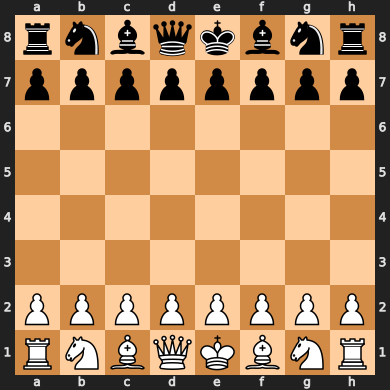

In [4]:
class Chess_Environment(gym.Env):
    """Chess Environment"""
    def __init__(self):
        self.board = chess.Board()
        self.white_pieces = ['P', 'N', 'B', 'R', 'Q', 'K']
        self.black_pieces = [piece.lower() for piece in self.white_pieces]
        self.x_coords, self.y_coords = np.meshgrid(list(range(0, 8)), list(range(0, 8)))
        self.x_coords = self.x_coords / 7
        self.y_coords = self.y_coords / 7
        self.state_size = self.observe()[0].shape
        self.init_action_decoder()
        self.whites_turn = True

    def reset(self):
        """Resets the environment"""
        self.board = chess.Board()
        
    def terminal_test(self):
        """Checks if the game is over"""
        return self.board.is_game_over(claim_draw = True)
    
    def result(self):
        """Gives the end game result"""

        result = self.board.result(claim_draw = True)
        if result == '1-0':
            return 1
        elif result == '0-1':
            return -1
        elif result == '1/2-1/2':
            return 0
        elif result == '*':
            return 0
        else:
            raise Exception('Invalid Result', result)
        
    def legal_actions(self):
        """Provides a list of legal actions in current state"""
        legal_actions = [str(legal_action) for legal_action in list(self.board.legal_moves)]
        return legal_actions
    
    def encode(self):
        """Encodes game state into a string"""
        board_ = self.board.piece_map()
            
        encoded = {
            'board' : board_,
            'turn' : self.board.turn,
            'legal_actions' : self.legal_actions()
        }
        
        return pickle.dumps(encoded)
    
    def decode(self, encoded):
        """Decodes string into game state and sets board and turn"""
        decoded = pickle.loads(encoded)
        self.board.set_piece_map(decoded['board'])
        if decoded['turn'] == False:
            self.board = self.board.mirror()
        self.board.turn = decoded['turn']

    def observe(self):
        """Create observation from the game state"""

        board_ = copy(self.board)
            
        board_ = np.ndarray.flatten(np.array(board_.__str__().split())).reshape(8, 8)
        
        black_pawns = np.isin(copy(board_), ['p']).astype(int)
        black_knights = np.isin(copy(board_), ['n']).astype(int)
        black_rooks = np.isin(copy(board_), ['r']).astype(int)
        black_bishops = np.isin(copy(board_), ['b']).astype(int)
        black_queen = np.isin(copy(board_), ['q']).astype(int)
        black_king = np.isin(copy(board_), ['k']).astype(int)
         
        white_pawns = np.isin(copy(board_), ['P']).astype(int)
        white_knights = np.isin(copy(board_), ['N']).astype(int)
        white_rooks = np.isin(copy(board_), ['R']).astype(int)
        white_bishops = np.isin(copy(board_), ['B']).astype(int)
        white_queen = np.isin(copy(board_), ['Q']).astype(int)
        white_king = np.isin(copy(board_), ['K']).astype(int)
        
        state = np.array([
            white_pawns,
            white_knights,
            white_rooks,
            white_bishops,
            white_queen,
            white_king,
            black_pawns,
            black_knights,
            black_rooks,
            black_bishops,
            black_queen,
            black_king
        ])
        
        return state, self.legal_actions()
    
    def step(self, action):
        """Perform a step in the environment"""
        try:
            self.board.push_uci(action)
        except ValueError:
#             print(f"INVALID ACTION {action}.\nSELECTING A RANDOM ACTION FROM LEGAL ACTIONS\n{self.legal_actions()}")
            actions = random.choices(self.legal_actions())
            self.board.push_uci(actions[0])
            
        self.board = self.board.mirror()
        if self.whites_turn:
            self.whites_turn = False
        else:
            self.whites_turn = True
        return self.observe()
    
    def move_board(self, move):
        """Moves the board positions as per the move"""

        char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

        int_to_char = {v: k for k, v in char_to_int.items()}

        encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(BOARD)]

        new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(BOARD)]
        moves = []
        for pos, new_pos in zip(np.ndarray.flatten(BOARD), new_board):
            try:
                if new_pos[1] > 8:
                    raise Exception()
                if move[2] is None:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
                else:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
                if '-' in move_:
                    raise Exception()
            
                if '0' in move_:
                    raise Exception()
                
            except Exception:
                move_ = 'XXXX'
            moves.append(move_)   
        return np.array(moves).reshape(8, 8)
    
    def init_action_decoder(self):
        """Initialize the decoder to decode the actions"""
        decoder = []
        for key in MOVES.keys():
            decoder_ = self.move_board(MOVES[key])
            decoder.append(decoder_)
#             print(f'Move {key}\n', new_board, '\n')
    
        self.decoder = np.array(decoder)
        self.action_size = self.decoder.shape
        
    def select_action(self, logits):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in self.legal_actions()}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))

        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        return action
    
    def render(self):
        """Render chess board"""
        chess.svg.board(board = self.board)  

env = Chess_Environment()
env.board

In [5]:
class EpisodicReplayBuffer:
    """
    Holds the agents episodes in memory
    """
    def __init__(self, params):
        self.capacity = params['capacity']
        self.memory = deque(maxlen = self.capacity)
        self.gamma = params['gamma']

    def add(self, episodes):
        """
        Stores the episodes in the replay buffer
        """
        for episode in episodes:
            if episode is not None:
                self.memory.append(episode)

    def sample(self, sample_size):
        """
        Return a sample of size of batch size as an experience tuple.
        """
        if len(self.memory) == 0:
            return None
        if len(self.memory) >= sample_size:
            batch = random.sample(self.memory, k = sample_size)
        else:
            batch = random.sample(self.memory, k = len(self.memory))
#         state, actions, returns_, dones = zip(*batch)

#         # Stacks the experiences 
#         # Get inputs into correct shape
#         states = torch.tensor(state).float().to(self.device)
# #         actions = torch.stack(actions).to(self.device)
#         returns_ = torch.tensor(returns_).float().to(self.device)
#         dones = torch.tensor(dones).float().to(self.device)
       
        # print("SAMPLE | STATES", states.shape, "ACTIONS", actions.shape, "P VECTORS", portfolio_vectors.shape,"NEXT STATES", next_states.shape, "REWARDS", rewards.shape, "DONES", dones.shape)
        
        return batch

    def reset_memory(self):
        """Resets the replay buffer"""
        self.memory = deque(maxlen = self.capacity)


In [6]:
class Agent:
    
    def __init__(self, decoder, action_size, vae, mdn, controller, test_mode = False, batch_size = 128, lr = 1e-4, legal_multiplier = 3, save_freq = 8, train_times = 4, lambda_ = 0.9, gamma = 0.98):
        self.batch_size = batch_size
        self.action_size = action_size
        self.trained_times = 0
        self.train_times = train_times
        self.lambda_ = lambda_
        self.gamma = gamma
        self.legal_multiplier = legal_multiplier # To increase the value of legal actions and MCTS insight as the target policy
        self.decoder = decoder
        self.save_freq = save_freq
        if vae is not None:
            self.vae = CNN_AE(vae, None, 'Latest')
            self.vae.eval()
        if mdn is not None:
            self.mdn = MDN_RNN(mdn, None, 'Latest')
            self.mdn.eval()
            params = {
                'hidden_size' : self.mdn.hidden_size,
                'z_size' : self.vae.z_size,
                'action_size' : action_size,
                'expansion_size': 1200
            }

            if test_mode:
                self.actor = Policy_Controller(controller, None, 'Latest')
                self.critic = Value_Controller(controller, None, 'Latest')
            else:
                self.actor = Policy_Controller(controller, params, False)
                self.critic = Value_Controller(controller, params, False)
                self.actor.save_model(0)
                self.critic.save_model(0)
        
            self.actor_optimizer = Adam(self.actor.parameters(), lr = lr)
            self.critic_optimizer = Adam(self.critic.parameters(), lr = lr)
        
        self.char_to_int = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8} 
        self.char_to_int_promo = {'r': 1, 'b': 2, 'q': 3, 'k': 4, 'n': 5, '': 6} 
        
        moves_df = pd.DataFrame(list(zip(self.char_to_int.values(), self.char_to_int.keys())), columns = ['Ids', 'Labels'])
        promo_df = pd.DataFrame(list(zip(self.char_to_int_promo.values(), self.char_to_int_promo.keys())), columns = ['Ids', 'Labels'])
        self.move_actions_ohe = pd.get_dummies(moves_df['Ids'])
        self.promo_actions_ohe = pd.get_dummies(promo_df['Ids'])
        
        self.criterion_pi = nn.NLLLoss()
        self.criterion_v = nn.SmoothL1Loss()
    
    def select_action(self, logits, legal_actions):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))
        
        legal_actions = list(legal_move_logits.keys())
        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        
        action_probabilities = {legal_actions[idx] : probabilities[idx] for idx in range(len(legal_actions))}
        return action, action_probabilities
    
    def one_hot_encode_action(self, action):
        """One hot encodes the action"""
        if len(action) == 4:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[''] - 1].values
            ]
        else:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[action[4]] - 1].values
            ]
        ohe_action = np.concatenate(encoded_action)
        return ohe_action
    
    def reset(self, batch_size):
        """Resets the MDNs hidden state"""
        self.hidden = self.mdn.init_hidden(batch_size)
        self.hidden = (self.hidden[0].detach().to('cpu'), self.hidden[1].detach().to('cpu'))
        
    def act(self, state, legal_actions):
        """Gets an action from the agent"""
        state = torch.tensor(state).float().unsqueeze(0)
        z = self.vae.encode(state)
    
        zh = torch.cat((z.to('cpu'), self.hidden[0].squeeze(0).to('cpu')), dim = 1)
        if zh.shape[0] > 1:
            raise Exception('Batch size > 1 not handled')
            
        logits = self.actor(zh)
        values = self.critic(zh)
        logits, value = logits.detach().squeeze(0).cpu().numpy(), values.detach().squeeze(0).cpu().numpy()[0]
        action, action_probabilities = self.select_action(logits, legal_actions)
        
        return action_probabilities, value, z
    
    def encode_z(self, state):
        """Encodes the state using the autoencoder"""
        state = torch.tensor(state).float().unsqueeze(0)
        return self.vae.encode(state)
    
    def train(self, episodes):
        """Trains the controller from the MCTS experiences"""
        all_zh = []
        all_returns = []
        all_mcts_action_probs = []
#         batches = [experiences[i : i + self.batch_size] for i in range(0, len(experiences), self.batch_size)]
        for idx, episode in enumerate(episodes):
            zh, mcts_action_probs, rewards, masks = zip(*episode)
            
            zh_ = torch.tensor(zh).float().unsqueeze(1)
            values = self.critic(zh_.to(self.critic.device))
            
            # Calculate GAE
            returns = []
            values_ = list(values.view(-1).detach().cpu().numpy())
            gae = 0

            for i in reversed(range(len(rewards))):
                if i == len(rewards) - 1:
                    delta = rewards[i] - values[i]
                else:
                    delta = rewards[i] + self.gamma * values[i + 1] * masks[i] - values[i]
                gae = delta + self.gamma * self.lambda_ * masks[i] * gae
                returns.insert(0, gae + values[i])
            all_returns.extend(returns)
            all_zh.extend(list(zh))
            all_mcts_action_probs.extend([x for x in mcts_action_probs])
            
#         all_returns = [item for sublist in all_returns for item in sublist]
#         all_zh = [item for sublist in all_zh for item in sublist]
#         all_mcts_action_probs = [item for sublist in all_mcts_action_probs for item in sublist]
        
        # Trains on random experiences to decoralate the information
        idxs = random.choices(range(len(all_zh)), k = self.batch_size)
        mcts_action_probs = [all_mcts_action_probs[idx] for idx in idxs]
        returns = torch.stack([torch.tensor(all_returns[idx]).float() for idx in idxs]).to(self.critic.device)
        actor_zh = torch.stack([torch.tensor(all_zh[idx]).float() for idx in idxs]).to(self.actor.device)
        critic_zh = actor_zh.clone().to(self.critic.device)
        
        logits = self.actor(actor_zh)
        values = self.critic(critic_zh)
                              
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
#             print(zh.is_cuda, type(zh))
        improvement_estimate = self.improvement_estimate(logits, mcts_action_probs)
        epsilon = 1e-7
#             print(logits.shape, torch.log(logits + epsilon))
#             print(improvement_estimate.shape, improvement_estimate)
            
        actor_losses = -improvement_estimate * torch.log(logits + epsilon)
        critic_losses = (returns.view(-1) - values.view(-1)).pow(2)
            
#             print(actor_losses)
#             print("IMP EST", improvement_estimate.shape, "LOGITS", logits.shape, "ACTOR LOSS", actor_losses.shape)
#             print("RETURNS", returns.view(-1).shape, "VALUES", values.view(-1).shape, "CRITIC LOSS", critic_losses.shape)

            
#             for idx in range(logits.shape[0]):
#                 advantage = returns[idx] - values[idx]
#                 # converts logits to action probabilities
# #                 print(values[idx].squeeze(0).shape, returns[idx].shape)
# #                 print(values[idx].squeeze(0), returns[idx])
#                 policy_losses.append(-F.softmax(logits[idx], dim = 0) * advantage)
#                 value_losses.append(F.smooth_l1_loss(values[idx].squeeze(0), returns[idx]))
            
            # sum up all the values of policy_losses and value_losses
        actor_loss = actor_losses.sum()
#             critic_loss = critic_losses.sum()
        critic_loss = critic_losses.sum()
            
#             writer.add_scalar('policy_loss', policy_loss, writer.games)
#             writer.add_scalar('value_loss_loss', value_loss, writer.games)
#             loss = policy_loss + value_loss
            
        print("ACTOR LOSS", actor_loss.item(), "| CRITIC LOSS", critic_loss.item())
        actor_loss.backward()
        self.actor_optimizer.step()
        critic_loss.backward()
        self.critic_optimizer.step()
        if self.trained_times % self.save_freq == 0:
            print("SAVING")
            self.actor.save_model(self.trained_times)
            self.critic.save_model(self.trained_times)
        self.trained_times += 1
        
    def load_hidden(self, hidden):
        """Loads the hidden state to the MDN RNN"""
        self.hidden = deepcopy(hidden)
        
    def get_hidden(self):
        """Gets the hidden state from the MDN RNN"""
        return deepcopy(self.hidden)
    
    def random_controller(self): 
        """Updates the controller from a randomly selected save file"""
        path = f'checkpoints_/{self.actor.type}/{self.actor.name}/'
        list_of_files = [x for x in os.listdir(path) if '.pth' in x]
        file_name = random.choice(list_of_files)
        print(f'Loading Random Controllers {file_name}')
        
        self.actor.load_model(file_name)
        self.critic.load_model(file_name)
        
    def step(self, z, action):
        """Updates the hidden state of the MDN-RNN"""
        z.squeeze_(-1)
        ohe_action = self.one_hot_encode_action(action)
        za = torch.cat((z.to('cpu'), torch.tensor(ohe_action).float().to('cpu').unsqueeze(0)), dim = 1)
        _, self.hidden = self.mdn(za.unsqueeze(1), self.hidden)
        self.hidden = (self.hidden[0].detach().to('cpu'), self.hidden[1].detach().to('cpu'))
        
                
    def improvement_estimate(self, logits, legal_move_logits):
        """Create an improvement estimate by layering the insights from MCTS"""
        new_boards__ = [[x.lower() for x in list(np.ndarray.flatten(self.decoder))] for _ in range(logits.shape[0])]
        improve_est = []
        for idx in range(logits.shape[0]):
            new_boards___ = new_boards__[idx]
            improve_est__ = logits[idx].clone().view(-1)
            improve_est__.data.fill_(0)
            legal_move_logits__ = {k.lower(): v * self.legal_multiplier for k, v in legal_move_logits[idx].items()}
            for move, legal_move_logit in legal_move_logits__.items():
                index = new_boards___.index(move)
                improve_est__[index] += legal_move_logit
            improve_est.append(improve_est__.reshape(76, 8, 8))
        return torch.stack(improve_est)
    
agent = Agent(env.decoder, env.action_size, 'Test', 'Test', 'Test', test_mode = False)
agent.reset(1)


AI Running on cpu

CNN_AE(
  (encoder): Sequential(
    (0): Conv(
      (conv): Conv2d(12, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (2): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (3): Conv(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (4): Conv(
      (conv): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1

In [ ]:
class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, env, agent, params):
        self.iterations = params['iterations']
        self.episodes = params['episodes']
        self.queue_length = params['queue_length']
        self.simulations = params['simulations']
        self.train_times = params['train_times']
        self.memory_samples = params['memory_samples']
        self.env = deepcopy(env)
        self.agent = agent
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.games = 0
        params = {
            'capacity' : 70,
            'gamma' : 0.98
        } 
        
        self.memory = EpisodicReplayBuffer(params)
    
    @ray.remote
    def execute_episode(self, agent, game):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.
        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.
        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        env = Chess_Environment()
        experiences = []
        agent.reset(1)
        mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = self.simulations)
        mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = self.simulations)  
        mcts_black.agent.random_controller()
        
        # RESET HIDDEN STATES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        game_move = 0
        
        terminal_test = env.terminal_test()
        while not terminal_test:
            encoded_state = env.encode()
            if env.whites_turn: 
                action_probs, zh = mcts_white.action_probabilities(encoded_state)
            else:
                action_probs, zh = mcts_black.action_probabilities(encoded_state)

            if env.whites_turn:
                experiences.append([zh.detach().cpu().numpy(), action_probs, 1, terminal_test]) # mask is 'not done'
            action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
            _, _ = env.step(action)
    
            game_move += 1
            terminal_test = env.terminal_test()
        
        reward = env.result()
        if not env.whites_turn and ((reward == 1) or (reward == -1)):
            reward = reward * -1
        
        experiences[-1][-1] = 0 # mask is 'not done'
        experiences[-1][-2] = reward
        
        if reward == -1:
            print(f"Game {game} White Loss")
        elif reward == 1:
            print(f"Game {game} White Won")
        else:
            print(f"Game {game} Draw")
            print("WARNING DELETING EXPERIENCES")
            return None
            
        

        return experiences
    
    def learn(self, ray):    
#     def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        
#         for i in range(1, self.iterations + 1):
        episodes = ray.get([self.execute_episode.remote(self, self.agent, self.games + idx) for idx in range(self.episodes)])
#         episodes = [self.execute_episode(self.agent, self.games + idx) for idx in range(self.episodes)]
        self.games += len(episodes)
        
        if episodes is not None:
            self.memory.add(episodes)
        for _ in range(self.train_times):
            episodes = self.memory.sample(self.memory_samples)
            if episodes is not None:
                self.agent.train(episodes)

#         # training new network, keeping a copy of the old one
#         self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         pmcts = MCTS(self.game, self.pnet, self.args)

#         
#         nmcts = MCTS(self.game, self.nnet, self.args)

#         log.info('PITTING AGAINST PREVIOUS VERSION')
#         arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
#                           lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
#         pwins, nwins, draws = arena.playGames(self.args.arenaCompare)

#         log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
#         if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
#             log.info('REJECTING NEW MODEL')
#             self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         else:
#             log.info('ACCEPTING NEW MODEL')
#             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
#             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')
        

params = {
    'iterations': 1,
    'episodes': 16,
    'queue_length' : 2000,
    'simulations' : 200,
    'train_times' : 10,
    'memory_samples' : 32
}

coach = Coach(env, agent, params)
for _ in range(1000):
    coach.learn(ray)
#     coach.learn()


(pid=15619) Loading Random Controllers E0.pth
(pid=15616) Loading Random Controllers E0.pth
(pid=15625) Loading Random Controllers E0.pth
(pid=15622) Loading Random Controllers E0.pth
(pid=15615) Loading Random Controllers E0.pth
(pid=15620) Loading Random Controllers E0.pth
(pid=15617) Loading Random Controllers E0.pth
(pid=15618) Loading Random Controllers E0.pth
(pid=15621) Loading Random Controllers E0.pth
(pid=15612) Loading Random Controllers E0.pth
(pid=15624) Loading Random Controllers E0.pth
(pid=15610) Loading Random Controllers E0.pth
(pid=15613) Loading Random Controllers E0.pth
(pid=15623) Loading Random Controllers E0.pth
(pid=15611) Loading Random Controllers E0.pth
(pid=15614) Loading Random Controllers E0.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,
(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,
(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: inv

(pid=15615) Game 4 White Won
(pid=15613) Game 12 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15621) Game 8 White Won
(pid=15622) Game 2 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 14 White Won
(pid=15616) Game 0 White Loss
(pid=15619) Game 1 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15625) Game 3 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15610) Game 11 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15618) Game 7 White Loss
(pid=15614) Game 15 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15612) Game 9 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15617) Game 6 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15623) Game 13 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15620) Game 5 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15624) Game 10 Draw
(pid=15624) WARNING DELETING EXPERIENCES


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:151: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629416375/work/torch/csrc/utils/tensor_numpy.cpp:141.)


ACTOR LOSS 1715.22216796875 | CRITIC LOSS 176.1524200439453
SAVING
ACTOR LOSS 1830.0140380859375 | CRITIC LOSS 173.7557830810547
ACTOR LOSS 2097.5029296875 | CRITIC LOSS 170.606689453125
ACTOR LOSS 2654.67626953125 | CRITIC LOSS 168.16082763671875
ACTOR LOSS 2604.507080078125 | CRITIC LOSS 164.86573791503906
ACTOR LOSS 2854.8525390625 | CRITIC LOSS 162.93539428710938
ACTOR LOSS 3018.4619140625 | CRITIC LOSS 158.22616577148438
ACTOR LOSS 3133.0498046875 | CRITIC LOSS 156.59120178222656
ACTOR LOSS 3201.103515625 | CRITIC LOSS 154.04150390625
SAVING
ACTOR LOSS 3259.1474609375 | CRITIC LOSS 152.24578857421875
(pid=15624) Loading Random Controllers E8.pth
(pid=15620) Loading Random Controllers E8.pth
(pid=15612) Loading Random Controllers E0.pth
(pid=15617) Loading Random Controllers E0.pth
(pid=15618) Loading Random Controllers E0.pth
(pid=15619) Loading Random Controllers E0.pth
(pid=15616) Loading Random Controllers E0.pth
(pid=15614) Loading Random Controllers E8.pth
(pid=15611) Loading

(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,
(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,
(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,
(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: inv

(pid=15618) Game 20 White Won
(pid=15612) Game 18 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15621) Game 27 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15613) Game 30 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15624) Game 16 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15610) Game 29 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15615) Game 31 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15620) Game 17 White Loss
(pid=15614) Game 23 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15619) Game 21 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15623) Game 28 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15617) Game 19 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15625) Game 25 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15622) Game 26 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 24 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15616) Game 22 Draw
(pid=15616) WARNING DELETING EXPERIENCES
ACTOR LOSS 3451

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,
(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E0.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15619) Loading Random Controllers E8.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15611) Loading Random Controllers E16.pth
(pid=15614) Loading Random Controllers E0.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E8.pth
(pid=15615) Loading Random Controllers E0.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15624) Loading Random Controllers E16.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15623) Loading Random Controllers E16.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E16.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E8.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15621) Loading Random Controllers E8.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15612) Loading Random Controllers E8.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15617) Loading Random Controllers E16.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E16.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15625) Game 34 White Won
(pid=15616) Game 32 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15621) Game 44 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15610) Game 42 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15613) Game 43 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15617) Game 46 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15624) Game 40 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15611) Game 36 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15614) Game 37 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15620) Game 38 White Loss
(pid=15619) Game 35 White Won
(pid=15618) Game 47 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15622) Game 33 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15623) Game 41 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15612) Game 45 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15615) Game 39 Draw
(pid=15615) WARNING DELETING EXPERIENCES
ACTOR LOSS 4594.9501953125 | CRITIC LOSS 154.099945

(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,
(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,



(pid=15619) Loading Random Controllers E0.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15620) Loading Random Controllers E0.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15614) Loading Random Controllers E24.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E8.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15624) Loading Random Controllers E8.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15618) Loading Random Controllers E0.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E0.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15623) Loading Random Controllers E8.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E8.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E8.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15621) Loading Random Controllers E0.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15616) Loading Random Controllers E8.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15622) Loading Random Controllers E16.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E24.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15619) Game 50 White Loss
(pid=15615) Game 48 White Loss
(pid=15610) Game 59 White Won
(pid=15625) Game 63 White Won
(pid=15617) Game 56 White Won
(pid=15613) Game 58 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15612) Game 49 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15611) Game 53 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15620) Game 51 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15624) Game 54 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15616) Game 61 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15614) Game 52 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15618) Game 55 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15621) Game 60 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15623) Game 57 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 62 Draw
(pid=15622) WARNING DELETING EXPERIENCES
ACTOR LOSS 5137.20263671875 | CRITIC LOSS 148.7867431640625
ACTOR LOSS 5170.158203125 | CRITIC LOSS 144.70657348632812
ACT

(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15616) Loading Random Controllers E24.pth
(pid=15624) Loading Random Controllers E8.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15620) Loading Random Controllers E32.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15614) Loading Random Controllers E32.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide

(pid=15611) Loading Random Controllers E16.pth



(pid=15611)   type=str,


(pid=15612) Loading Random Controllers E24.pth
(pid=15618) Loading Random Controllers E32.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,
(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E8.pth
(pid=15622) Loading Random Controllers E8.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E16.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15623) Loading Random Controllers E8.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E32.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E0.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15615) Loading Random Controllers E0.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15619) Loading Random Controllers E32.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15614) Game 68 White Won
(pid=15616) Game 65 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15618) Game 71 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15619) Game 79 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15623) Game 75 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15621) Game 64 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15611) Game 69 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15615) Game 78 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15625) Game 74 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15620) Game 67 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15617) Game 72 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15624) Game 66 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15622) Game 73 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15613) Game 76 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15612) Game 70 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15610) Game 77 Draw
(pid=15610) WARNING D

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E16.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15620) Loading Random Controllers E0.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15622) Loading Random Controllers E24.pth
(pid=15625) Loading Random Controllers E32.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15615) Loading Random Controllers E32.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15621) Loading Random Controllers E48.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15610) Loading Random Controllers E0.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E16.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E24.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15619) Loading Random Controllers E40.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15617) Loading Random Controllers E24.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E32.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15616) Loading Random Controllers E40.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15611) Loading Random Controllers E0.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E16.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15624) Game 81 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15611) Game 94 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15625) Game 84 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15619) Game 90 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15612) Game 80 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15623) Game 89 White Won
(pid=15616) Game 93 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15615) Game 85 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15614) Game 95 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15620) Game 82 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15621) Game 86 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15613) Game 88 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15617) Game 91 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15610) Game 87 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15622) Game 83 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15618) Game 92 Draw
(pid=15618) WARNING D

(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E0.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15621) Loading Random Controllers E48.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E40.pth
(pid=15615) Loading Random Controllers E8.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15616) Loading Random Controllers E56.pth
(pid=15610) Loading Random Controllers E8.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E8.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E0.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15612) Loading Random Controllers E0.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15619) Loading Random Controllers E48.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15622) Loading Random Controllers E56.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E0.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15614) Loading Random Controllers E48.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E8.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15624) Loading Random Controllers E24.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15616) Game 101 White Won
(pid=15618) Game 96 White Loss
(pid=15610) Game 102 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15614) Game 109 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15623) Game 104 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 107 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15625) Game 108 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15620) Game 99 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15619) Game 106 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15615) Game 100 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15611) Game 110 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15612) Game 105 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15624) Game 111 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15621) Game 98 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15613) Game 103 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15617) Game 97 Draw
(pid=15617) WARNING DELETING EXPERIENCES
ACT

(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15621) Loading Random Controllers E48.pth
(pid=15624) Loading Random Controllers E40.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15612) Loading Random Controllers E40.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15615) Loading Random Controllers E24.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15619) Loading Random Controllers E0.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15620) Loading Random Controllers E48.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15625) Loading Random Controllers E64.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E48.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15611) Loading Random Controllers E56.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E0.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15613) Loading Random Controllers E8.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E64.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E24.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E16.pth
(pid=15618) Loading Random Controllers E8.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15616) Loading Random Controllers E24.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15610) Game 124 White Loss
(pid=15619) Game 116 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15616) Game 127 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15625) Game 118 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15615) Game 115 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15617) Game 125 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15614) Game 121 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15613) Game 122 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15624) Game 113 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15621) Game 112 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15623) Game 123 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 119 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 120 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15612) Game 114 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15620) Game 117 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15618) Game 126 Draw
(pid

(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15612) Loading Random Controllers E72.pth
(pid=15621) Loading Random Controllers E24.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E64.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15611) Loading Random Controllers E48.pth
(pid=15614) Loading Random Controllers E24.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15618) Loading Random Controllers E48.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15617) Loading Random Controllers E72.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15615) Loading Random Controllers E16.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15622) Loading Random Controllers E8.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15625) Loading Random Controllers E0.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15616) Loading Random Controllers E56.pth
(pid=15619) Loading Random Controllers E32.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15623) Loading Random Controllers E32.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15613) Loading Random Controllers E24.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E56.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Game 141 White Loss
(pid=15613) Game 142 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15622) Game 137 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15618) Game 134 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15619) Game 140 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15616) Game 139 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15620) Game 128 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15621) Game 130 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15624) Game 131 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15610) Game 143 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15611) Game 132 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15614) Game 133 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15617) Game 135 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15615) Game 136 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15612) Game 129 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15625) Game 138 Draw
(pid

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15612) Loading Random Controllers E8.pth
(pid=15615) Loading Random Controllers E48.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,
(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide

(pid=15614) Loading Random Controllers E16.pth



(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E48.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15624) Loading Random Controllers E64.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15621) Loading Random Controllers E56.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15620) Loading Random Controllers E88.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15616) Loading Random Controllers E72.pth
(pid=15619) Loading Random Controllers E48.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15617) Loading Random Controllers E72.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E40.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15625) Loading Random Controllers E80.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E16.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15610) Loading Random Controllers E0.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E56.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E32.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15623) Game 159 White Loss
(pid=15620) Game 150 White Won
(pid=15618) Game 154 White Won
(pid=15616) Game 151 White Loss
(pid=15624) Game 148 White Won
(pid=15611) Game 147 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15615) Game 145 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15614) Game 146 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15622) Game 156 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15621) Game 149 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15619) Game 152 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15625) Game 155 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15610) Game 157 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15617) Game 153 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15613) Game 158 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15612) Game 144 Draw
(pid=15612) WARNING DELETING EXPERIENCES
ACTOR LOSS 5818.40478515625 | CRITIC LOSS 82.40231323242188
ACTOR LOSS 5862.33984375 | CRITIC LOSS 80.2607

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15619) Loading Random Controllers E64.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15621) Loading Random Controllers E32.pth
(pid=15625) Loading Random Controllers E48.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E48.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15615) Loading Random Controllers E80.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15614) Loading Random Controllers E72.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15611) Loading Random Controllers E32.pth
(pid=15624) Loading Random Controllers E40.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15616) Loading Random Controllers E80.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E40.pth
(pid=15618) Loading Random Controllers E40.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15620) Loading Random Controllers E40.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15613) Loading Random Controllers E48.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E8.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E8.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15612) Game 160 White Won
(pid=15620) Game 172 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15616) Game 169 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15617) Game 170 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15610) Game 174 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15614) Game 166 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15622) Game 164 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15623) Game 175 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15613) Game 173 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15624) Game 168 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15621) Game 162 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15618) Game 171 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15615) Game 165 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15625) Game 163 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15619) Game 161 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15611) Game 167 Draw
(pid=

(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,
(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15615) Loading Random Controllers E48.pth
(pid=15621) Loading Random Controllers E48.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15624) Loading Random Controllers E80.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15625) Loading Random Controllers E64.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E64.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15611) Loading Random Controllers E80.pth
(pid=15614) Loading Random Controllers E0.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15613) Loading Random Controllers E72.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E80.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15610) Loading Random Controllers E16.pth
(pid=15618) Loading Random Controllers E40.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E24.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15616) Loading Random Controllers E96.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15620) Loading Random Controllers E16.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15612) Loading Random Controllers E0.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Game 179 White Loss
(pid=15619) Game 176 White Won
(pid=15610) Game 186 White Won
(pid=15616) Game 189 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15620) Game 190 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15618) Game 187 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15621) Game 178 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15615) Game 177 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15623) Game 185 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15625) Game 180 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15613) Game 184 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15617) Game 188 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15612) Game 191 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15611) Game 182 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15614) Game 183 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15622) Game 181 Draw
(pid=15622) WARNING DELETING EXPERIENCES
ACTOR LOSS 5921.27978515625 | CRITI

(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E80.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15612) Loading Random Controllers E16.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15622) Loading Random Controllers E8.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E48.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15615) Loading Random Controllers E96.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15621) Loading Random Controllers E32.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15617) Loading Random Controllers E16.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E88.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15620) Loading Random Controllers E0.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15616) Loading Random Controllers E72.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15613) Loading Random Controllers E32.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E80.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E112.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15619) Loading Random Controllers E80.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15624) Loading Random Controllers E88.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15617) Game 199 White Won
(pid=15622) Game 195 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15620) Game 201 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15611) Game 193 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15623) Game 204 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15612) Game 194 White Loss
(pid=15624) Game 207 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15615) Game 197 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15610) Game 205 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15618) Game 200 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15619) Game 206 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15625) Game 196 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15621) Game 198 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15613) Game 203 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15614) Game 192 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15616) Game 202 Draw
(pid=15616) WARNING DELETING EXPERIENCES

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15621) Loading Random Controllers E56.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15619) Loading Random Controllers E72.pth
(pid=15615) Loading Random Controllers E104.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,
(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15624) Loading Random Controllers E120.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15612) Loading Random Controllers E40.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,
(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15613) Loading Random Controllers E40.pth
(pid=15610) Loading Random Controllers E104.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E40.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15614) Loading Random Controllers E16.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E64.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15620) Loading Random Controllers E120.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15625) Loading Random Controllers E104.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E112.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15618) Loading Random Controllers E56.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E104.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15612) Game 213 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15611) Game 218 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15624) Game 212 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15625) Game 220 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15620) Game 219 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15614) Game 217 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15619) Game 210 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15623) Game 216 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15616) Game 208 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15610) Game 215 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15618) Game 222 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15615) Game 211 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15622) Game 221 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15613) Game 214 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15621) Game 209 Draw
(pid=15621) WARNING DELETING EXPERIE

(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15615) Loading Random Controllers E80.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15617) Loading Random Controllers E120.pth
(pid=15618) Loading Random Controllers E120.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,
(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15616) Loading Random Controllers E64.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15613) Loading Random Controllers E136.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E0.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E24.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15619) Loading Random Controllers E40.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15620) Loading Random Controllers E88.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15622) Loading Random Controllers E56.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E0.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15624) Loading Random Controllers E80.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15614) Loading Random Controllers E0.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E64.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15612) Loading Random Controllers E0.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15613) Game 229 White Loss
(pid=15622) Game 234 White Won
(pid=15619) Game 232 White Won
(pid=15620) Game 233 White Loss
(pid=15610) Game 230 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15615) Game 225 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15612) Game 239 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15617) Game 226 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15611) Game 238 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15614) Game 237 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15623) Game 231 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15618) Game 227 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15621) Game 224 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15624) Game 236 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15625) Game 235 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15616) Game 228 Draw
(pid=15616) WARNING DELETING EXPERIENCES
ACTOR LOSS 5914.44482421875 | CRITIC LOSS 53.288848876953125
ACTOR LOS

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15624) Loading Random Controllers E128.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15621) Loading Random Controllers E88.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15614) Loading Random Controllers E128.pth
(pid=15611) Loading Random Controllers E0.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15618) Loading Random Controllers E72.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E40.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,
(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15615) Loading Random Controllers E64.pth
(pid=15612) Loading Random Controllers E128.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15620) Loading Random Controllers E56.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15619) Loading Random Controllers E88.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15625) Loading Random Controllers E56.pth
(pid=15622) Loading Random Controllers E16.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15623) Loading Random Controllers E120.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E88.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E32.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15612) Game 248 White Loss
(pid=15623) Game 253 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15613) Game 255 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15610) Game 254 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15624) Game 241 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15625) Game 251 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15620) Game 249 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15619) Game 250 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15618) Game 245 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15622) Game 252 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15615) Game 247 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15614) Game 243 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15616) Game 240 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15611) Game 244 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15621) Game 242 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15617) Game 246 Draw
(pid

(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15616) Loading Random Controllers E88.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15611) Loading Random Controllers E64.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E56.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15615) Loading Random Controllers E96.pth
(pid=15617) Loading Random Controllers E96.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E40.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,
(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15619) Loading Random Controllers E32.pth
(pid=15620) Loading Random Controllers E64.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15622) Loading Random Controllers E48.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E80.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15624) Loading Random Controllers E24.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15610) Loading Random Controllers E104.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E56.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E8.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15612) Loading Random Controllers E96.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15615) Game 260 White Won
(pid=15624) Game 267 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15621) Game 256 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15616) Game 257 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15625) Game 266 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15623) Game 270 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 265 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15619) Game 263 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15620) Game 264 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15618) Game 262 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15617) Game 261 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15612) Game 271 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15613) Game 269 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15614) Game 259 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15610) Game 268 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15611) Game 258 Draw
(pid=

(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15611) Loading Random Controllers E104.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15614) Loading Random Controllers E48.pth
(pid=15612) Loading Random Controllers E128.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15617) Loading Random Controllers E0.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E40.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15620) Loading Random Controllers E104.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15619) Loading Random Controllers E128.pth
(pid=15610) Loading Random Controllers E0.pth
(pid=15613) Loading Random Controllers E24.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,
(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E144.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15622) Loading Random Controllers E96.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E96.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15616) Loading Random Controllers E80.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15621) Loading Random Controllers E16.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15624) Loading Random Controllers E24.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15615) Loading Random Controllers E40.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15611) Game 272 White Won
(pid=15621) Game 285 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15612) Game 274 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15615) Game 287 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15623) Game 281 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15614) Game 273 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15610) Game 279 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15613) Game 280 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15624) Game 286 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15625) Game 283 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15617) Game 275 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15618) Game 276 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15622) Game 282 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15619) Game 278 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15620) Game 277 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15616) Game 284 Draw
(pid=

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15620) Loading Random Controllers E48.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15619) Loading Random Controllers E24.pth
(pid=15618) Loading Random Controllers E16.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,
(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E48.pth
(pid=15622) Loading Random Controllers E80.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E64.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15624) Loading Random Controllers E160.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15613) Loading Random Controllers E32.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E120.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E152.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15615) Loading Random Controllers E120.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15612) Loading Random Controllers E144.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15621) Loading Random Controllers E96.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15614) Loading Random Controllers E176.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E40.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15619) Game 290 White Loss
(pid=15625) Game 294 White Loss
(pid=15614) Game 302 White Loss
(pid=15616) Game 288 White Won
(pid=15612) Game 300 White Won
(pid=15613) Game 296 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15623) Game 298 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15617) Game 292 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15620) Game 289 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15621) Game 301 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15611) Game 303 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15624) Game 295 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15618) Game 291 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15610) Game 297 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15615) Game 299 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15622) Game 293 Draw
(pid=15622) WARNING DELETING EXPERIENCES
ACTOR LOSS 5858.255859375 | CRITIC LOSS 18.986282348632812
ACTOR LOSS 5852.74755859375 | CRITIC LOSS 17.8

(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15624) Loading Random Controllers E144.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15621) Loading Random Controllers E128.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E120.pth
(pid=15618) Loading Random Controllers E128.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E40.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15610) Loading Random Controllers E104.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E24.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E88.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15612) Loading Random Controllers E24.pth
(pid=15616) Loading Random Controllers E176.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15611) Loading Random Controllers E32.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E56.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15622) Loading Random Controllers E64.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E64.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15619) Loading Random Controllers E136.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15615) Game 304 White Won
(pid=15614) Game 316 White Won
(pid=15621) Game 306 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15619) Game 319 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15620) Game 307 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15625) Game 318 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15617) Game 309 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15613) Game 312 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15611) Game 315 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15610) Game 310 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15618) Game 308 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15616) Game 314 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15612) Game 313 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15624) Game 305 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15623) Game 311 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 317 Draw
(pid=15622) WARNING DELETING EXPERIENCES


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15612) Loading Random Controllers E160.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15616) Loading Random Controllers E168.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15623) Loading Random Controllers E112.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E48.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E8.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,
(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15618) Loading Random Controllers E144.pth
(pid=15617) Loading Random Controllers E136.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15622) Loading Random Controllers E136.pth
(pid=15625) Loading Random Controllers E184.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15620) Loading Random Controllers E64.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15619) Loading Random Controllers E56.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15621) Loading Random Controllers E112.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15611) Loading Random Controllers E176.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E136.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15615) Loading Random Controllers E16.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15618) Game 326 White Won
(pid=15615) Game 335 White Won
(pid=15619) Game 331 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15621) Game 332 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15612) Game 321 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15624) Game 320 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15614) Game 334 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15616) Game 322 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15623) Game 323 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15613) Game 325 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15611) Game 333 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15610) Game 324 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15620) Game 330 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15617) Game 327 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15622) Game 328 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15625) Game 329 Draw
(pid=15625) WARNING DELETING EXPERIENCES


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,
(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15622) Loading Random Controllers E96.pth
(pid=15620) Loading Random Controllers E64.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15610) Loading Random Controllers E16.pth
(pid=15613) Loading Random Controllers E8.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E16.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15616) Loading Random Controllers E120.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15611) Loading Random Controllers E144.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E64.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15624) Loading Random Controllers E184.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15612) Loading Random Controllers E176.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15621) Loading Random Controllers E32.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15619) Loading Random Controllers E120.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15615) Loading Random Controllers E192.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15617) Loading Random Controllers E112.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E104.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15622) Game 337 White Won
(pid=15624) Game 345 White Loss
(pid=15621) Game 347 White Loss
(pid=15620) Game 338 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15612) Game 346 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15610) Game 339 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15623) Game 341 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15613) Game 340 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15625) Game 336 White Won
(pid=15614) Game 344 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15618) Game 351 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15611) Game 343 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15619) Game 348 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15617) Game 350 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15616) Game 342 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15615) Game 349 Draw
(pid=15615) WARNING DELETING EXPERIENCES
ACTOR LOSS 5987.31787109375 | CRITIC LOSS 15.742810249328613
ACTOR LOS

(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15616) Loading Random Controllers E184.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15619) Loading Random Controllers E120.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15617) Loading Random Controllers E64.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E40.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15611) Loading Random Controllers E8.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,
(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15614) Loading Random Controllers E168.pth
(pid=15613) Loading Random Controllers E96.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E16.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E192.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15612) Loading Random Controllers E64.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15620) Loading Random Controllers E112.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15621) Loading Random Controllers E40.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15624) Loading Random Controllers E0.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15625) Loading Random Controllers E96.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E208.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15614) Game 358 White Won
(pid=15619) Game 354 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15612) Game 362 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15622) Game 367 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15615) Game 352 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15621) Game 364 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15617) Game 355 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15620) Game 363 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15625) Game 366 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15610) Game 361 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15618) Game 356 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15616) Game 353 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15611) Game 357 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15624) Game 365 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15613) Game 359 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15623) Game 360 Draw
(pid=

(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15616) Loading Random Controllers E32.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15623) Loading Random Controllers E168.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E80.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15610) Loading Random Controllers E0.pth
(pid=15620) Loading Random Controllers E200.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15618) Loading Random Controllers E192.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E200.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15621) Loading Random Controllers E64.pth
(pid=15615) Loading Random Controllers E160.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15625) Loading Random Controllers E32.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,
(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15622) Loading Random Controllers E160.pth
(pid=15612) Loading Random Controllers E104.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15619) Loading Random Controllers E208.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15611) Loading Random Controllers E192.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E104.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15613) Game 371 White Loss
(pid=15624) Game 368 White Won
(pid=15618) Game 374 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15611) Game 382 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15619) Game 381 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15610) Game 372 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15621) Game 376 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15614) Game 383 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15612) Game 380 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15616) Game 369 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15622) Game 379 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15625) Game 378 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15623) Game 370 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15620) Game 373 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15617) Game 375 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15615) Game 377 Draw
(pid=15615) WARNING DELETING EXPERIENCES

(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E152.pth
(pid=15625) Loading Random Controllers E128.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E136.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15616) Loading Random Controllers E48.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15612) Loading Random Controllers E136.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15621) Loading Random Controllers E104.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15619) Loading Random Controllers E216.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15614) Loading Random Controllers E168.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E112.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15617) Loading Random Controllers E160.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E144.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15624) Loading Random Controllers E88.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15623) Loading Random Controllers E232.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E128.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E176.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15614) Game 392 White Loss
(pid=15621) Game 390 White Won
(pid=15615) Game 384 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15622) Game 387 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15619) Game 391 White Loss
(pid=15624) Game 396 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15610) Game 398 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15617) Game 394 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15616) Game 388 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15620) Game 385 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15612) Game 389 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15625) Game 386 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15611) Game 393 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15623) Game 397 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15618) Game 395 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15613) Game 399 Draw
(pid=15613) WARNING DELETING EXPERIENCES
ACTOR LOSS 5983.31689453125 | CRIT

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15620) Loading Random Controllers E232.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15616) Loading Random Controllers E0.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,
(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15618) Loading Random Controllers E224.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E240.pth
(pid=15613) Loading Random Controllers E208.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E240.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E200.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15624) Loading Random Controllers E56.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15619) Loading Random Controllers E56.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15625) Loading Random Controllers E160.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E96.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15615) Loading Random Controllers E8.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15621) Loading Random Controllers E136.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15611) Loading Random Controllers E200.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E48.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15623) Game 406 White Loss
(pid=15610) Game 407 White Loss
(pid=15616) Game 402 White Won
(pid=15617) Game 404 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15624) Game 408 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15619) Game 409 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15615) Game 412 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15622) Game 411 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 414 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15625) Game 410 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15613) Game 405 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15614) Game 415 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15618) Game 403 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15621) Game 413 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15620) Game 401 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15612) Game 400 Draw
(pid=15612) WARNING DELETING EXPERIENCES
ACTOR LOSS 6016.69091796875 | CRIT

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15620) Loading Random Controllers E80.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15621) Loading Random Controllers E56.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15614) Loading Random Controllers E168.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E256.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15625) Loading Random Controllers E176.pth
(pid=15622) Loading Random Controllers E136.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15615) Loading Random Controllers E8.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15619) Loading Random Controllers E24.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15624) Loading Random Controllers E120.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15618) Loading Random Controllers E8.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E256.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15616) Loading Random Controllers E88.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15613) Loading Random Controllers E16.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E144.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E152.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15620) Game 417 White Won
(pid=15625) Game 421 White Loss
(pid=15614) Game 419 White Won
(pid=15613) Game 429 White Loss
(pid=15624) Game 425 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15612) Game 416 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15619) Game 424 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15617) Game 427 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15622) Game 422 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 420 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15615) Game 423 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15621) Game 418 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15610) Game 430 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15618) Game 426 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15623) Game 431 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15616) Game 428 Draw
(pid=15616) WARNING DELETING EXPERIENCES
ACTOR LOSS 6100.404296875 | CRITIC LOSS 8.10372543334961
ACTOR LOSS 60

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15621) Loading Random Controllers E160.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15615) Loading Random Controllers E96.pth
(pid=15618) Loading Random Controllers E184.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E80.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15619) Loading Random Controllers E0.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,
(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15612) Loading Random Controllers E88.pth
(pid=15624) Loading Random Controllers E16.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15623) Loading Random Controllers E88.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E200.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E176.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15611) Loading Random Controllers E112.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E144.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15622) Loading Random Controllers E40.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E200.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15620) Loading Random Controllers E40.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15612) Game 438 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15610) Game 441 White Won
(pid=15622) Game 445 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15618) Game 435 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15624) Game 439 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15614) Game 444 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15619) Game 437 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15625) Game 446 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15611) Game 443 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15617) Game 436 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15615) Game 434 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15620) Game 447 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15623) Game 440 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15621) Game 433 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15613) Game 442 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15616) Game 432 Draw
(pid=

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15621) Loading Random Controllers E96.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E40.pth
(pid=15615) Loading Random Controllers E200.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15619) Loading Random Controllers E176.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15611) Loading Random Controllers E8.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E56.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15624) Loading Random Controllers E272.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15617) Loading Random Controllers E152.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E72.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15625) Loading Random Controllers E200.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E64.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15613) Loading Random Controllers E112.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E152.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E0.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15612) Loading Random Controllers E32.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15613) Game 460 White Won
(pid=15625) Game 458 White Loss
(pid=15616) Game 448 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15623) Game 461 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15619) Game 452 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15621) Game 449 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15612) Game 463 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15624) Game 455 White Won
(pid=15615) Game 451 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15617) Game 456 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15611) Game 453 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15620) Game 450 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15618) Game 457 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15610) Game 462 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15614) Game 454 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15622) Game 459 Draw
(pid=15622) WARNING DELETING EXPERIENCES
ACTOR LOSS 6022.7470703125 | CRITIC

(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15614) Loading Random Controllers E16.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15611) Loading Random Controllers E40.pth
(pid=15618) Loading Random Controllers E120.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E288.pth
(pid=15615) Loading Random Controllers E224.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15624) Loading Random Controllers E24.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15612) Loading Random Controllers E24.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15621) Loading Random Controllers E104.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15619) Loading Random Controllers E40.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15616) Loading Random Controllers E232.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15622) Loading Random Controllers E8.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E224.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15610) Loading Random Controllers E136.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E160.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E152.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15613) Game 479 White Won
(pid=15615) Game 469 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15622) Game 475 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 466 White Loss
(pid=15621) Game 472 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15623) Game 478 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15620) Game 464 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15612) Game 471 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15616) Game 474 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15618) Game 467 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15617) Game 468 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15614) Game 465 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15624) Game 470 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15619) Game 473 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15625) Game 476 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15610) Game 477 Draw
(pid=15610) WARNING DELETING EXPERIENCES

(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15619) Loading Random Controllers E96.pth
(pid=15624) Loading Random Controllers E112.pth
(pid=15617) Loading Random Controllers E264.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E16.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15616) Loading Random Controllers E216.pth
(pid=15612) Loading Random Controllers E248.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E120.pth
(pid=15621) Loading Random Controllers E184.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15614) Loading Random Controllers E208.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E184.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15625) Loading Random Controllers E80.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E208.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15615) Loading Random Controllers E240.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15610) Loading Random Controllers E152.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E8.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E88.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15624) Game 481 White Loss
(pid=15613) Game 495 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15611) Game 489 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15625) Game 490 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15622) Game 491 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15614) Game 488 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15610) Game 493 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15623) Game 494 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15621) Game 487 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15617) Game 482 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15618) Game 483 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15612) Game 485 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15619) Game 480 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15615) Game 492 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15620) Game 486 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15616) Game 484 Draw
(pid

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15620) Loading Random Controllers E16.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15615) Loading Random Controllers E104.pth
(pid=15619) Loading Random Controllers E120.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15612) Loading Random Controllers E208.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15618) Loading Random Controllers E40.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E24.pth
(pid=15621) Loading Random Controllers E112.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15622) Loading Random Controllers E48.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E64.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15614) Loading Random Controllers E104.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E56.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15623) Loading Random Controllers E8.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E136.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E184.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15624) Loading Random Controllers E200.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15617) Game 502 White Loss
(pid=15613) Game 510 White Won
(pid=15622) Game 504 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15616) Game 496 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15615) Game 498 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15610) Game 509 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15625) Game 505 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15618) Game 501 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15621) Game 503 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15623) Game 508 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15619) Game 499 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15612) Game 500 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15614) Game 506 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15611) Game 507 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15624) Game 511 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15620) Game 497 Draw
(pid=15620) WARNING DELETING EXPERIENCES

(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15620) Loading Random Controllers E24.pth
(pid=15624) Loading Random Controllers E248.pth
(pid=15611) Loading Random Controllers E200.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E112.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15612) Loading Random Controllers E128.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,
(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15619) Loading Random Controllers E280.pth
(pid=15621) Loading Random Controllers E184.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15615) Loading Random Controllers E96.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15616) Loading Random Controllers E288.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15625) Loading Random Controllers E312.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E24.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15623) Loading Random Controllers E32.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E152.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E120.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15618) Loading Random Controllers E232.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E184.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15620) Game 512 White Loss
(pid=15619) Game 517 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15625) Game 521 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15624) Game 513 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15617) Game 527 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15616) Game 520 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15610) Game 524 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15622) Game 522 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15621) Game 518 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15612) Game 516 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15614) Game 515 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15613) Game 525 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15618) Game 526 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15611) Game 514 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15615) Game 519 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15623) Game 523 Draw
(pid

(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15611) Loading Random Controllers E208.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E112.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15612) Loading Random Controllers E88.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15621) Loading Random Controllers E232.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15623) Loading Random Controllers E240.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E64.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E272.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15616) Loading Random Controllers E200.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15618) Loading Random Controllers E208.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E144.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15624) Loading Random Controllers E88.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15622) Loading Random Controllers E200.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E128.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15619) Loading Random Controllers E152.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15620) Loading Random Controllers E304.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15618) Game 537 White Loss
(pid=15622) Game 540 White Loss
(pid=15620) Game 543 White Won
(pid=15620) 
(pid=15625) Game 541 White Won
(pid=15614) Game 530 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15624) Game 539 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15621) Game 532 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15617) Game 538 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15619) Game 542 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15613) Game 534 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15612) Game 531 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15615) Game 528 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15610) Game 535 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15623) Game 533 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15611) Game 529 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15616) Game 536 Draw
(pid=15616) WARNING DELETING EXPERIENCES
ACTOR LOSS 6040.9755859375 | CRITIC LOSS 12.3863868713378

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15615) Loading Random Controllers E288.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15612) Loading Random Controllers E312.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15623) Loading Random Controllers E104.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E208.pth
(pid=15613) Loading Random Controllers E80.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,
(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15619) Loading Random Controllers E48.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15621) Loading Random Controllers E96.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15624) Loading Random Controllers E40.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15611) Loading Random Controllers E168.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,
(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15614) Loading Random Controllers E8.pth
(pid=15620) Loading Random Controllers E120.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15625) Loading Random Controllers E272.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E40.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15617) Loading Random Controllers E96.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E48.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Game 558 White Loss
(pid=15619) Game 550 White Loss
(pid=15620) Game 555 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15612) Game 546 White Won
(pid=15613) Game 549 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15621) Game 551 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15615) Game 545 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15623) Game 547 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15610) Game 548 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15616) Game 544 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15618) Game 559 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15624) Game 552 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15611) Game 553 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15625) Game 556 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15614) Game 554 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15622) Game 557 Draw
(pid=15622) WARNING DELETING EXPERIENCES
ACTOR LOSS 6089.52587890625 | CRIT

(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15622) Loading Random Controllers E72.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15625) Loading Random Controllers E24.pth
(pid=15614) Loading Random Controllers E168.pth
(pid=15611) Loading Random Controllers E72.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15624) Loading Random Controllers E184.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15616) Loading Random Controllers E344.pth
(pid=15615) Loading Random Controllers E8.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15621) Loading Random Controllers E224.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15610) Loading Random Controllers E336.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E312.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E72.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15612) Loading Random Controllers E288.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15620) Loading Random Controllers E280.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15619) Loading Random Controllers E344.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15618) Loading Random Controllers E104.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E64.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15616) Game 565 White Won
(pid=15619) Game 573 White Won
(pid=15615) Game 566 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15611) Game 563 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15622) Game 560 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15618) Game 574 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15620) Game 572 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15613) Game 570 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15621) Game 567 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15625) Game 561 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15623) Game 569 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15624) Game 564 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15617) Game 575 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15610) Game 568 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15614) Game 562 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15612) Game 571 Draw
(pid=15612) WARNING DELETING EXPERIENCES


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E104.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15621) Loading Random Controllers E0.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15610) Loading Random Controllers E72.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E320.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E240.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15620) Loading Random Controllers E256.pth
(pid=15617) Loading Random Controllers E336.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E80.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15625) Loading Random Controllers E32.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E120.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15614) Loading Random Controllers E168.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E152.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15615) Loading Random Controllers E24.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15619) Loading Random Controllers E208.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15616) Loading Random Controllers E24.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15618) Game 584 White Won
(pid=15624) Game 577 White Won
(pid=15617) Game 583 White Won
(pid=15613) Game 581 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15610) Game 579 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15611) Game 588 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15612) Game 576 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15619) Game 590 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15620) Game 582 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15623) Game 580 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 586 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15616) Game 591 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15615) Game 589 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15625) Game 585 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15614) Game 587 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15621) Game 578 Draw
(pid=15621) WARNING DELETING EXPERIENCES
ACTOR LOSS 6092.2177734375 | CRITIC 

(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15615) Loading Random Controllers E0.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15616) Loading Random Controllers E176.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15625) Loading Random Controllers E232.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E56.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15620) Loading Random Controllers E24.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15619) Loading Random Controllers E200.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15612) Loading Random Controllers E264.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15614) Loading Random Controllers E104.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15611) Loading Random Controllers E264.pth
(pid=15623) Loading Random Controllers E184.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E248.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E64.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15624) Loading Random Controllers E152.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15617) Loading Random Controllers E224.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E168.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15619) Game 598 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15618) Game 607 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15614) Game 600 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15615) Game 593 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15610) Game 603 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15621) Game 592 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15623) Game 602 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15611) Game 601 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15620) Game 597 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15616) Game 594 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15622) Game 596 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15624) Game 605 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15613) Game 604 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15612) Game 599 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15617) Game 606 Draw
(pid=15617) WARNING DELETING EXPERIE

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E272.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15625) Loading Random Controllers E112.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E112.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15616) Loading Random Controllers E96.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15620) Loading Random Controllers E312.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15621) Loading Random Controllers E288.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15613) Loading Random Controllers E24.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E216.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E328.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15615) Loading Random Controllers E280.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15611) Loading Random Controllers E112.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E376.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15617) Loading Random Controllers E216.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E320.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15619) Loading Random Controllers E280.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15614) Game 620 White Won
(pid=15613) Game 615 White Won
(pid=15624) Game 609 White Won
(pid=15619) Game 623 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15620) Game 613 White Won
(pid=15612) Game 608 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15617) Game 621 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15625) Game 610 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15618) Game 622 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15611) Game 619 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15610) Game 617 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15616) Game 612 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15623) Game 616 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15615) Game 618 White Loss
(pid=15621) Game 614 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15622) Game 611 Draw
(pid=15622) WARNING DELETING EXPERIENCES
ACTOR LOSS 5591.38134765625 | CRITIC LOSS 8.403467178344727
ACTOR LOSS 6107.2724609375 | CRITIC LOSS 10.618

(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15615) Loading Random Controllers E72.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15616) Loading Random Controllers E384.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15622) Loading Random Controllers E136.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15625) Loading Random Controllers E32.pth
(pid=15618) Loading Random Controllers E120.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E272.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,
(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15612) Loading Random Controllers E136.pth
(pid=15620) Loading Random Controllers E120.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15619) Loading Random Controllers E72.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15624) Loading Random Controllers E64.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15623) Loading Random Controllers E216.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15610) Loading Random Controllers E320.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E376.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15611) Loading Random Controllers E56.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E16.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15625) Game 628 White Loss
(pid=15618) Game 629 White Loss
(pid=15611) Game 638 White Loss
(pid=15621) Game 624 White Won
(pid=15623) Game 635 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15617) Game 630 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15620) Game 632 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15613) Game 637 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15615) Game 625 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15616) Game 626 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15612) Game 631 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15619) Game 633 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15614) Game 639 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15624) Game 634 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15622) Game 627 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15610) Game 636 Draw
(pid=15610) WARNING DELETING EXPERIENCES
ACTOR LOSS 5711.7685546875 | CRITIC LOSS 12.431253433227539
ACTOR LOS

(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15619) Loading Random Controllers E40.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15612) Loading Random Controllers E328.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15616) Loading Random Controllers E48.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15615) Loading Random Controllers E208.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15620) Loading Random Controllers E392.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15610) Loading Random Controllers E80.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E88.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E104.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15621) Loading Random Controllers E320.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15614) Loading Random Controllers E96.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E120.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15617) Loading Random Controllers E168.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E352.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15622) Loading Random Controllers E200.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E376.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15618) Game 653 White Loss
(pid=15625) Game 655 White Loss
(pid=15617) Game 652 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15616) Game 643 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15612) Game 642 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15613) Game 647 White Won
(pid=15623) Game 648 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15614) Game 650 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15621) Game 649 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15624) Game 640 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15620) Game 645 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15610) Game 646 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15615) Game 644 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15622) Game 654 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 651 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15619) Game 641 Draw
(pid=15619) WARNING DELETING EXPERIENCES
ACTOR LOSS 5794.50439453125 | CRIT

(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15615) Loading Random Controllers E48.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15620) Loading Random Controllers E376.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15624) Loading Random Controllers E352.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15621) Loading Random Controllers E192.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15611) Loading Random Controllers E64.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E224.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15610) Loading Random Controllers E400.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E112.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E96.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15612) Loading Random Controllers E408.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15616) Loading Random Controllers E176.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15622) Loading Random Controllers E296.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E352.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15617) Loading Random Controllers E272.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E400.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15618) Game 671 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15614) Game 662 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15613) Game 665 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15612) Game 666 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15624) Game 659 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15620) Game 658 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15611) Game 661 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15617) Game 670 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15619) Game 656 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15622) Game 668 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15616) Game 667 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15623) Game 664 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15615) Game 657 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15610) Game 663 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15621) Game 660 Draw
(pid=15621) WARNING DELETING EXPERIE

(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15615) Loading Random Controllers E160.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15616) Loading Random Controllers E64.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15625) Loading Random Controllers E232.pth
(pid=15622) Loading Random Controllers E280.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15619) Loading Random Controllers E384.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15620) Loading Random Controllers E248.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15624) Loading Random Controllers E136.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15612) Loading Random Controllers E192.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15610) Loading Random Controllers E176.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E392.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E120.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15611) Loading Random Controllers E264.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E40.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15617) Loading Random Controllers E152.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E8.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15622) Game 676 White Won
(pid=15614) Game 685 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15620) Game 678 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15615) Game 673 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15617) Game 686 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15611) Game 684 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15613) Game 683 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15625) Game 675 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15623) Game 682 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15624) Game 679 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15612) Game 680 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15616) Game 674 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15618) Game 687 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15621) Game 672 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15619) Game 677 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15610) Game 681 Draw
(pid=

(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15621) Loading Random Controllers E336.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15616) Loading Random Controllers E16.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15612) Loading Random Controllers E272.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,
(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15624) Loading Random Controllers E416.pth
(pid=15610) Loading Random Controllers E168.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E64.pth
(pid=15613) Loading Random Controllers E104.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,
(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15618) Loading Random Controllers E128.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E328.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15615) Loading Random Controllers E128.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15620) Loading Random Controllers E256.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15611) Loading Random Controllers E56.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E144.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15625) Loading Random Controllers E152.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E56.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15614) Game 701 White Loss
(pid=15619) Game 688 White Won
(pid=15615) Game 698 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15616) Game 690 White Loss
(pid=15620) Game 699 White Won
(pid=15612) Game 691 White Loss
(pid=15622) Game 703 White Won
(pid=15623) Game 694 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15613) Game 695 White Loss
(pid=15621) Game 689 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15624) Game 692 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15617) Game 697 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15610) Game 693 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15618) Game 696 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15611) Game 700 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15625) Game 702 Draw
(pid=15625) WARNING DELETING EXPERIENCES
ACTOR LOSS 6141.67724609375 | CRITIC LOSS 9.866357803344727
ACTOR LOSS 6101.8935546875 | CRITIC LOSS 9.939102172851562
ACTOR LOSS 5788.38134765625 | CRITIC LOSS 12.482867240905

(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,
(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15617) Loading Random Controllers E400.pth
(pid=15624) Loading Random Controllers E432.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,
(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15621) Loading Random Controllers E328.pth
(pid=15610) Loading Random Controllers E144.pth
(pid=15613) Loading Random Controllers E416.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E0.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15625) Loading Random Controllers E112.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E136.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15612) Loading Random Controllers E184.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15620) Loading Random Controllers E376.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15616) Loading Random Controllers E200.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15615) Loading Random Controllers E16.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15619) Loading Random Controllers E136.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15611) Loading Random Controllers E8.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E56.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15610) Game 708 White Loss
(pid=15613) Game 709 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15616) Game 715 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15617) Game 705 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15615) Game 716 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15614) Game 719 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15619) Game 717 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15620) Game 714 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15624) Game 706 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15622) Game 712 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15611) Game 718 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15623) Game 710 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15621) Game 707 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15612) Game 713 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15625) Game 711 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15618) Game 704 Draw
(pid

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15621) Loading Random Controllers E376.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15625) Loading Random Controllers E368.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E176.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15624) Loading Random Controllers E160.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E40.pth
(pid=15619) Loading Random Controllers E272.pth
(pid=15611) Loading Random Controllers E80.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,
(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E248.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15615) Loading Random Controllers E136.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15618) Loading Random Controllers E440.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E152.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15616) Loading Random Controllers E144.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15623) Loading Random Controllers E376.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E432.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E200.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15624) Game 724 White Won
(pid=15612) Game 720 White Won
(pid=15621) Game 721 White Won
(pid=15620) Game 725 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15610) Game 735 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15616) Game 732 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15613) Game 734 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15625) Game 722 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15617) Game 731 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15622) Game 723 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15619) Game 726 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15615) Game 729 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15614) Game 728 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15618) Game 730 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15623) Game 733 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15611) Game 727 Draw
(pid=15611) WARNING DELETING EXPERIENCES
ACTOR LOSS 6153.791015625 | CRITIC L

(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E80.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15615) Loading Random Controllers E432.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15619) Loading Random Controllers E392.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15618) Loading Random Controllers E80.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E240.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15622) Loading Random Controllers E32.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E392.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15616) Loading Random Controllers E160.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15623) Loading Random Controllers E160.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E144.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15610) Loading Random Controllers E416.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15620) Loading Random Controllers E288.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15621) Loading Random Controllers E208.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15612) Loading Random Controllers E96.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E0.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15625) Game 743 White Won
(pid=15621) Game 749 White Won
(pid=15611) Game 736 White Won
(pid=15618) Game 740 White Won
(pid=15616) Game 744 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15620) Game 748 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15614) Game 737 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15615) Game 738 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15619) Game 739 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15623) Game 745 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 742 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15624) Game 751 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15613) Game 746 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15617) Game 741 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15610) Game 747 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15612) Game 750 Draw
(pid=15612) WARNING DELETING EXPERIENCES
ACTOR LOSS 6140.7919921875 | CRITIC LOSS 13.836650848388672
ACTOR LOSS 6

(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E288.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15610) Loading Random Controllers E464.pth
(pid=15613) Loading Random Controllers E248.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E416.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15619) Loading Random Controllers E64.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15615) Loading Random Controllers E56.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15620) Loading Random Controllers E280.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,
(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15616) Loading Random Controllers E368.pth
(pid=15617) Loading Random Controllers E8.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15618) Loading Random Controllers E376.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15614) Loading Random Controllers E432.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E208.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15621) Loading Random Controllers E112.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15622) Loading Random Controllers E368.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E376.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15613) Game 755 White Won
(pid=15617) Game 761 White Loss
(pid=15618) Game 762 White Loss
(pid=15621) Game 765 White Won
(pid=15615) Game 758 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15620) Game 759 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15625) Game 767 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15614) Game 763 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15624) Game 753 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15623) Game 756 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15610) Game 754 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15619) Game 757 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15622) Game 766 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15612) Game 752 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15616) Game 760 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15611) Game 764 Draw
(pid=15611) WARNING DELETING EXPERIENCES
ACTOR LOSS 6173.8076171875 | CRITIC LOSS 6.4375529289245605
ACTOR LOSS

(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15612) Loading Random Controllers E128.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15619) Loading Random Controllers E464.pth


(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15624) Loading Random Controllers E224.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15611) Loading Random Controllers E280.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15614) Loading Random Controllers E16.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15622) Loading Random Controllers E368.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15625) Loading Random Controllers E264.pth
(pid=15620) Loading Random Controllers E208.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15615) Loading Random Controllers E360.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15621) Loading Random Controllers E472.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15618) Loading Random Controllers E136.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E72.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15610) Loading Random Controllers E224.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15623) Loading Random Controllers E72.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15613) Loading Random Controllers E456.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Game 782 White Loss
(pid=15615) Game 777 White Won
(pid=15620) Game 776 White Won
(pid=15617) Game 780 White Won
(pid=15611) Game 772 Draw
(pid=15611) WARNING DELETING EXPERIENCES
(pid=15624) Game 771 Draw
(pid=15624) WARNING DELETING EXPERIENCES
(pid=15613) Game 783 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15612) Game 769 Draw
(pid=15612) WARNING DELETING EXPERIENCES
(pid=15621) Game 778 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15614) Game 773 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15610) Game 781 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15616) Game 768 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15622) Game 774 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15619) Game 770 Draw
(pid=15619) WARNING DELETING EXPERIENCES
(pid=15618) Game 779 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15625) Game 775 Draw
(pid=15625) WARNING DELETING EXPERIENCES
ACTOR LOSS 5766.865234375 | CRITIC LOSS 9.117308616638184
SAVING
ACTOR 

(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15625) Loading Random Controllers E480.pth


(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15622) Loading Random Controllers E264.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,


(pid=15616) Loading Random Controllers E472.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15621) Loading Random Controllers E96.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15612) Loading Random Controllers E56.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E24.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


(pid=15614) Loading Random Controllers E208.pth


(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15611) Loading Random Controllers E80.pth
(pid=15618) Loading Random Controllers E464.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,
(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E168.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,
(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15620) Loading Random Controllers E0.pth
(pid=15615) Loading Random Controllers E168.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,


(pid=15610) Loading Random Controllers E400.pth


(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E336.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15623) Loading Random Controllers E368.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,


(pid=15624) Game 790 White Loss
(pid=15612) Game 789 White Won
(pid=15611) Game 792 White Won
(pid=15615) Game 796 Draw
(pid=15615) WARNING DELETING EXPERIENCES
(pid=15613) Game 798 Draw
(pid=15613) WARNING DELETING EXPERIENCES
(pid=15614) Game 791 Draw
(pid=15614) WARNING DELETING EXPERIENCES
(pid=15621) Game 788 Draw
(pid=15621) WARNING DELETING EXPERIENCES
(pid=15616) Game 787 Draw
(pid=15616) WARNING DELETING EXPERIENCES
(pid=15625) Game 785 Draw
(pid=15625) WARNING DELETING EXPERIENCES
(pid=15610) Game 797 Draw
(pid=15610) WARNING DELETING EXPERIENCES
(pid=15623) Game 799 Draw
(pid=15623) WARNING DELETING EXPERIENCES
(pid=15622) Game 786 Draw
(pid=15622) WARNING DELETING EXPERIENCES
(pid=15617) Game 794 Draw
(pid=15617) WARNING DELETING EXPERIENCES
(pid=15618) Game 793 Draw
(pid=15618) WARNING DELETING EXPERIENCES
(pid=15620) Game 795 Draw
(pid=15620) WARNING DELETING EXPERIENCES
(pid=15619) Game 784 Draw
(pid=15619) WARNING DELETING EXPERIENCES
ACTOR LOSS 5906.6572265625 | CRITIC

(pid=15619) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15619)   type=str,


(pid=15620) Loading Random Controllers E32.pth


(pid=15620) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15620)   type=str,


(pid=15618) Loading Random Controllers E48.pth


(pid=15618) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15618)   type=str,


(pid=15617) Loading Random Controllers E416.pth


(pid=15617) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15617)   type=str,


(pid=15622) Loading Random Controllers E48.pth


(pid=15622) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15622)   type=str,
(pid=15625) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15625)   type=str,


(pid=15625) Loading Random Controllers E456.pth
(pid=15616) Loading Random Controllers E64.pth


(pid=15616) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15616)   type=str,


(pid=15621) Loading Random Controllers E224.pth


(pid=15621) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15621)   type=str,


(pid=15623) Loading Random Controllers E280.pth
(pid=15610) Loading Random Controllers E472.pth


(pid=15623) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15623)   type=str,
(pid=15610) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15610)   type=str,


(pid=15613) Loading Random Controllers E32.pth


(pid=15613) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15613)   type=str,


(pid=15615) Loading Random Controllers E16.pth


(pid=15615) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15615)   type=str,
(pid=15614) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15614)   type=str,


(pid=15614) Loading Random Controllers E64.pth
(pid=15611) Loading Random Controllers E432.pth


(pid=15611) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15611)   type=str,


(pid=15612) Loading Random Controllers E248.pth


(pid=15612) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15612)   type=str,


(pid=15624) Loading Random Controllers E264.pth


(pid=15624) /home/ec2-user/.local/lib/python3.6/site-packages/ray/workers/default_worker.py:58: RuntimeWarning: invalid value encountered in true_divide
(pid=15624)   type=str,


# ALPHA GO TIPS 


## MCTS
Each simulation proceeds by
selecting in each state s a move a with low visit count, high move probability and high value
(averaged over the leaf states of simulations that selected a from s) according to the current
neural network fθ. The search returns a vector π representing a probability distribution over
moves, either proportionally or greedily with respect to the visit counts at the root state.
The parameters θ of the deep neural network in AlphaZero are trained by self-play reinforcement learning, starting from randomly initialised parameters θ. Games are played by selecting
moves for both players by MCTS, at ∼ πt
. At the end of the game, the terminal position sT is
scored according to the rules of the game to compute the game outcome z: −1 for a loss, 0 for
a draw, and +1 for a win. The neural network parameters θ are updated so as to minimise the
error between the predicted outcome vt and the game outcome z, and to maximise the similarity
of the policy vector pt
to the search probabilities πt
. Specifically, the parameters θ are adjusted
by gradient descent on a loss function l that sums over mean-squared error and cross-entropy
losses respectively

(p, v) = fθ(s)                    

l = (z − v) 2 − π > log p + c||θ||2


In [ ]:
class MCTS():
    """Monte Carlo Tree Search Algorithm geared for Neural Networks"""

    def __init__(self, env, agent, mcts_simulations = 100, max_depth = 100, delta = 0.5):
        self.env = env
        self.agent = agent
        self.cpuct = 1.5    # WARNING BULLSHIT NUMBER!
        self.delta = delta  # value to prevent crash if no edges are visited
        self.mcts_simulations = mcts_simulations
        self.max_depth = max_depth
        
        self.Qsa = {}       # stores Q values for s, a (as defined in the paper)
        self.Nsa = {}       # stores # times edge s, a was visited
        self.Ns = {}        # stores # times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores victory result (1, 0, -1) ended for board s
        self.Vs = {}        # stores legal actions for board s
        self.z = {}         # stores the features of the state
        self.hidden = {}    # stores the hidden states

    def action_probabilities(self, encoded_state, temp = 1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for runs in range(self.mcts_simulations):
#             print(f"{Fore.BLUE}MCTS SIMULATION {runs + 1}{Style.RESET_ALL}")
            self.search(encoded_state, 0)
        
        s = encoded_state
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in legal_actions]
        # counts array represent the number of time each action edge from your current state was traversed
        
        # temprature is 0 representing taking the best action possible (greedy)
        if temp == 0: 
            # bestA: best action number : argmax Returns the indices of the maximum values
            bestA = np.argmax(counts) 
            probs = [0] * len(counts)
            probs[bestA] = 1
            action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
            # returns the definite move(s) with same greedy reward, out of which one move HAS to be played
            return action_probs 
        
#         print(f"{Fore.BLUE}COUNTS {sum(counts)} {counts}{Style.RESET_ALL}")
        
        # Handles frequent draw situation when MCTS fails to explore when the game is over resulting 0 counts causing div 0 error
        if sum(counts) == 0:
            counts = [1 for _ in counts]
            
        counts = [x ** (1. / temp) + 0.5 for x in counts]
        probs = [x / float(sum(counts)) for x in counts]
        action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
        zh = torch.cat((self.z[s].to('cpu'), self.hidden[s][0].squeeze(0).to('cpu')), dim = 1)
#         print(zh)
        return action_probs, zh
        #returns the probablity of different moves that CAN be played resulting in uniform distribution


    def search(self, encoded_state, depth):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propogated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propogated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = deepcopy(encoded_state)
        self.env.decode(encoded_state)
#         print(f"{Fore.GREEN}SEARCH DEPTH {depth}{Style.RESET_ALL}")
        
        # Check if its an terminal state, -1 Opponent Won, 0 Game not Over, 1 Player Won
        if s not in self.Es:
            self.Es[s] = self.env.result()
        
        # Handles the maintaining of the MDNs hidden states
        if s not in self.hidden:
            self.hidden[s] = self.agent.get_hidden()
        else:
            self.agent.load_hidden(self.hidden[s])
        
        # Checks if the game is over and returns the respective value
        if self.env.terminal_test():
            state, _ = self.env.observe()
            self.z[s] = self.agent.encode_z(state)
            
#             print("SIMULATION OVER!", self.env.terminal_test(), -self.Es[s], self.env.board.result())
            return -self.Es[s]          
        
        state, legal_actions = self.env.observe()

        # if the current state 's' is not explored/expanded before n = 0 by MCTS then create a new node and rollout
        if s not in self.Ps: 
            self.Ps[s], v, self.z[s] = self.agent.act(state, legal_actions)
#             print("self.Ps[s] at Depth", depth, "\n", self.Ps[s])
            valids = legal_actions

            self.Vs[s] = valids 
            self.Ns[s] = 0
#             print("VALUE", -v)
            return -v

        # as already visited the valid moves array 'Vs' is already initialized
        valids = self.Vs[s] 
        cur_best = -float('inf')
        best_act = -1
        
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        # pick the action with the highest upper confidence bound
        
        agent_actions = list(self.Ps[s].keys())
        
        # Handles the occasional legal action that isn't an actual legal action
        # Pawn side cut even though there is no enemy piece in respective position
#         print("XXXXX PRE LEGAL ACTIONS\n", legal_actions)
        if not set(agent_actions) == set(legal_actions):
            legal_actions = agent_actions
#         print("XXXXX POST LEGAL ACTIONS\n", legal_actions)
        for a in legal_actions:
            if (s,a) in self.Qsa:
                u = self.Qsa[(s,a)] + self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (1 + self.Nsa[(s,a)])
#                 print("In Qsa")
            else:
                self.Ps[s][a] 
                u = self.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s])     # Q = 0 ? : node exists but not explored as added and initilized during nnet phase
#                 print("Not In Qsa", self.Ps[s][a], self.Ns[s], math.sqrt(self.Ns[s]))
#             print("U", u)
            if math.isnan(u):
                u = 0
#                 print("Override U", u)
            if u > cur_best:
                cur_best = u
                best_act = a
#         print(f"{Fore.GREEN}BEST ACTION {best_act}{Style.RESET_ALL}")
        a = best_act

        _, _ = self.env.step(a)
        self.agent.step(self.z[s], a)
        
        encoded_next_state = self.env.encode()

        v = self.search(encoded_next_state, depth + 1) # RECURSION until leaf node or terminal node is found
        
        self.env.decode(encoded_state)
        
        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)] * self.Qsa[(s,a)] + v) / (self.Nsa[(s,a)] + 1) #update the Q Value
            self.Nsa[(s,a)] += 1 # increment number of visits to this node in MCTS
        else:
            self.Qsa[(s,a)] = v # initialize the new node
            self.Nsa[(s,a)] = 1

        self.Ns[s] += 1
        return -v
    
    def reset(self):
        """Resets the tracked information"""
        self.Qsa = {}       
        self.Nsa = {}       
        self.Ns = {}        
        self.Ps = {}       
        self.Es = {}
        self.Vs = {}  
        self.zh = {}
        self.hidden = {}
        self.agent.reset(1)
        self.env.reset()

# for _ in range(5):
#     env.reset()
#     mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
#     mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
#     game_move = 0
#     while not env.terminal_test():
#     #     print(f"{Fore.RED}GAME MOVE {game_move}{Style.RESET_ALL}")
#         encoded_state = env.encode()
#         if env.whites_turn: 
#             action_probs, zh = mcts_white.action_probabilities(encoded_state)
#         else:
#             action_probs, zh = mcts_black.action_probabilities(encoded_state)
        
        
# #         print(game_move, env.whites_turn, env.terminal_test(), type(zh))
# #         if zh == None:
# #             print(encoded_state)
#         action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
# #         print(f"{Fore.CYAN}ACTUAL MOVE\n {action_probs}{Style.RESET_ALL}")
#         _, _ = env.step(action)
    
#         game_move += 1    
#     print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! GAME COMPLETED !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

### Training Loop

In [ ]:
# # COPY THIS
# # https://github.com/suragnair/alpha-zero-general/blob/master/Coach.py

# env.reset()
# mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
# mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = 20)
# game_move = 0

# while not env.terminal_test():
#     print(f"{Fore.RED}GAME MOVE {game_move}{Style.RESET_ALL}")
#     encoded_state = env.encode()
#     if env.whites_turn: 
#         action_probs = mcts_white.action_probabilities(encoded_state)
#     else:
#         action_probs = mcts_black.action_probabilities(encoded_state)
#     action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
#     print(f"{Fore.CYAN}ACTUAL MOVE\n {action_probs}{Style.RESET_ALL}")
#     _, _ = env.step(action)
    
#     game_move += 1
        
# print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! GAME COMPLETED !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

In [ ]:
# env.decode(b'\x80\x03}q\x00(X\x05\x00\x00\x00boardq\x01}q\x02(K<cchess\nPiece\nq\x03)\x81q\x04}q\x05(X\n\x00\x00\x00piece_typeq\x06K\x02X\x05\x00\x00\x00colorq\x07\x88ubK9h\x03)\x81q\x08}q\t(h\x06K\x06h\x07\x89ubK8h\x03)\x81q\n}q\x0b(h\x06K\x04h\x07\x89ubK5h\x03)\x81q\x0c}q\r(h\x06K\x01h\x07\x89ubK1h\x03)\x81q\x0e}q\x0f(h\x06K\x01h\x07\x89ubK0h\x03)\x81q\x10}q\x11(h\x06K\x01h\x07\x89ubK)h\x03)\x81q\x12}q\x13(h\x06K\x01h\x07\x88ubK&h\x03)\x81q\x14}q\x15(h\x06K\x01h\x07\x89ubK\x1dh\x03)\x81q\x16}q\x17(h\x06K\x01h\x07\x89ubK\x1ch\x03)\x81q\x18}q\x19(h\x06K\x01h\x07\x88ubK\x1bh\x03)\x81q\x1a}q\x1b(h\x06K\x01h\x07\x89ubK\x1ah\x03)\x81q\x1c}q\x1d(h\x06K\x01h\x07\x88ubK\x19h\x03)\x81q\x1e}q\x1f(h\x06K\x02h\x07\x89ubK\x14h\x03)\x81q }q!(h\x06K\x03h\x07\x89ubK\x0ch\x03)\x81q"}q#(h\x06K\x03h\x07\x88ubK\x08h\x03)\x81q$}q%(h\x06K\x01h\x07\x88ubK\x06h\x03)\x81q&}q\'(h\x06K\x04h\x07\x89ubK\x05h\x03)\x81q(}q)(h\x06K\x06h\x07\x88ubK\x01h\x03)\x81q*}q+(h\x06K\x02h\x07\x88ubK\x00h\x03)\x81q,}q-(h\x06K\x04h\x07\x88ubuX\x04\x00\x00\x00turnq.\x88X\r\x00\x00\x00legal_actionsq/]q0u.')
# env.board

In [ ]:
# class Coach():
#     """
#     This class executes the self-play + learning. It uses the functions defined
#     in Game and NeuralNet. args are specified in main.py.
#     """

#     def __init__(self, env, agent, params):
#         self.iterations = params['iterations']
#         self.episodes = params['episodes']
#         self.queue_length = params['queue_length']
#         self.env = deepcopy(env)
#         self.agent = agent
#         self.mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = params['simulations'])
#         self.mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = params['simulations'])
#         self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
#         self.games = 0

#     def executeEpisode(self):
#         """
#         This function executes one episode of self-play, starting with player 1.
#         As the game is played, each turn is added as a training example to
#         trainExamples. The game is played till the game ends. After the game
#         ends, the outcome of the game is used to assign values to each example
#         in trainExamples.
#         It uses a temp=1 if episodeStep < tempThreshold, and thereafter
#         uses temp=0.
#         Returns:
#             trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
#                            pi is the MCTS informed policy vector, v is +1 if
#                            the player eventually won the game, else -1.
#         """
#         experiences = []
#         self.env.reset()
#         # RESET HIDDEN STATES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#         game_move = 0
#         while not self.env.terminal_test():
#             encoded_state = self.env.encode()
#             if self.env.whites_turn: 
#                 action_probs, zh = self.mcts_white.action_probabilities(encoded_state)
#             else:
#                 action_probs, zh = self.mcts_black.action_probabilities(encoded_state)
# #             if zh is not None:
# #                 print("ZH NOT NONE")
#             experiences.append([zh.detach().cpu().numpy(), self.env.whites_turn, action_probs, None])
# #             else:
# #                 print("ZH NONE")
#             action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
#             _, _ = self.env.step(action)
    
#             game_move += 1
        
#         reward = self.env.result()
#         print(f"Game {self.games} Score {reward}")
#         experiences_ = []
#         DISCOUNT_GAMMA = 0.95
        
#         for idx, experience in enumerate(experiences):
#             reward_ = reward
#             # calculates the discounted return from the reward.. 
#             # / 2 becauses it contains experiences of both black and white
#             return_ = reward_ * (DISCOUNT_GAMMA ** (len(experiences) - idx) / 2)
#             if experience[1] != self.env.whites_turn and (reward_ == 1 or reward_ == -1):
#                 return_ *= -1
#             experiences_.append((experience[0], experience[2], return_))
#         return experiences_
    
    
#     def learn(self):
#         """
#         Performs numIters iterations with numEps episodes of self-play in each
#         iteration. After every iteration, it retrains neural network with
#         examples in trainExamples (which has a maximum length of maxlenofQueue).
#         It then pits the new neural network against the old one and accepts it
#         only if it wins >= updateThreshold fraction of games.
#         """
#         # deletes historical experiences so AI to enable online learning
#         self.trainExamplesHistory = []
        
#         for i in range(1, self.iterations + 1):
#             iterationTrainExamples = deque([], maxlen = self.queue_length)
#             for _ in tnrange(self.episodes, desc = "Self Play"):
#                 iterationTrainExamples += self.executeEpisode()
#                 self.games += 1

#             # save the iteration examples to the history 
#             self.trainExamplesHistory.append(iterationTrainExamples)

#         # shuffle examples before training
#         trainExamples = []
#         for e in self.trainExamplesHistory:
#             trainExamples.extend(e)
#         shuffle(trainExamples)
#         print(len(trainExamples))
        
#         self.agent.train(trainExamples)
#         self.mcts_white.agent = deepcopy(self.agent)
#         self.mcts_black.agent = deepcopy(self.agent)
        
#         self.mcts_white.reset()  # reset search tree as agents brain is now different
#         self.mcts_black.reset()
        

# #         # training new network, keeping a copy of the old one
# #         self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
# #         self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
# #         pmcts = MCTS(self.game, self.pnet, self.args)

# #         
# #         nmcts = MCTS(self.game, self.nnet, self.args)

# #         log.info('PITTING AGAINST PREVIOUS VERSION')
# #         arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
# #                           lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
# #         pwins, nwins, draws = arena.playGames(self.args.arenaCompare)

# #         log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
# #         if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
# #             log.info('REJECTING NEW MODEL')
# #             self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
# #         else:
# #             log.info('ACCEPTING NEW MODEL')
# #             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
# #             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')
        

# params = {
#     'iterations': 1,
#     'episodes': 5,
#     'queue_length' : 2000,
#     'simulations' : 200
# }
# coach = Coach(env, agent, params)
# for _ in range(1000):
#     coach.learn()

### Coach Parallel

In [ ]:
# ray.init()

In [ ]:

# class Coach():
#     """
#     This class executes the self-play + learning. It uses the functions defined
#     in Game and NeuralNet. args are specified in main.py.
#     """

#     def __init__(self, env, agent, params):
#         self.iterations = params['iterations']
#         self.episodes = params['episodes']
#         self.queue_length = params['queue_length']
#         self.simulations = params['simulations']
#         self.env = deepcopy(env)
#         self.agent = agent
#         self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
#         self.games = 0
    
# #     @ray.remote
#     def execute_episode(self, agent, game):
#         """
#         This function executes one episode of self-play, starting with player 1.
#         As the game is played, each turn is added as a training example to
#         trainExamples. The game is played till the game ends. After the game
#         ends, the outcome of the game is used to assign values to each example
#         in trainExamples.
#         It uses a temp=1 if episodeStep < tempThreshold, and thereafter
#         uses temp=0.
#         Returns:
#             trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
#                            pi is the MCTS informed policy vector, v is +1 if
#                            the player eventually won the game, else -1.
#         """
#         env = Chess_Environment()
#         experiences = []
#         mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = self.simulations)
#         mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = self.simulations)  
#         mcts_black.agent.random_controller()
#         # RESET HIDDEN STATES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#         game_move = 0
#         while not env.terminal_test():
#             encoded_state = env.encode()
#             if env.whites_turn: 
#                 action_probs, zh = mcts_white.action_probabilities(encoded_state)
#             else:
#                 action_probs, zh = mcts_black.action_probabilities(encoded_state)
# #             if zh is not None:
# #                 print("ZH NOT NONE")
#             if env.whites_turn:
#                 experiences.append([zh.detach().cpu().numpy(), env.whites_turn, action_probs, None])
# #             else:
# #                 print("ZH NONE")
#             action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
#             _, _ = env.step(action)
    
#             game_move += 1
        
#         reward = env.result()
#         if not env.whites_turn and ((reward == 1) or (reward == -1)):
#             reward = reward * -1
        
#         if reward == -1:
#             print(f"Game {game} White Loss")
#         elif reward == 1:
#             print(f"Game {game} White Won")
#         else:
#             print(f"Game {game} Draw")
#         experiences_ = []
#         DISCOUNT_GAMMA = 0.98
        
#         for idx, experience in enumerate(experiences):
#             if idx == len(experiences) - 1:
#                 done = 1
#             else: 
#                 done = 0
#             reward_ = reward
#             # calculates the discounted return from the reward.. 
#             # / 2 becauses it contains experiences of both black and white
#             return_ = reward_ * (DISCOUNT_GAMMA ** (len(experiences) - idx))
# #             if experience[1] != env.whites_turn and (reward_ == 1 or reward_ == -1):
# #                 return_ *= -1
#             experiences_.append((experience[0], experience[2], return_, done))
#         return experiences_
    
# #     def learn(self, ray):    
#     def learn(self):
#         """
#         Performs numIters iterations with numEps episodes of self-play in each
#         iteration. After every iteration, it retrains neural network with
#         examples in trainExamples (which has a maximum length of maxlenofQueue).
#         It then pits the new neural network against the old one and accepts it
#         only if it wins >= updateThreshold fraction of games.
#         """
#         # deletes historical experiences so AI to enable online learning
#         self.trainExamplesHistory = []
        
#         for i in range(1, self.iterations + 1):
# #             iterationTrainExamples = ray.get([self.execute_episode.remote(self, self.agent, self.games + idx) for idx in range(self.episodes)])
#             iterationTrainExamples = [self.execute_episode(self.agent, self.games + idx) for idx in range(self.episodes)]
#             self.games += len(iterationTrainExamples)
# #             iterationTrainExamples = [item for sublist in iterationTrainExamples for item in sublist]
# #             for _ in tnrange(self.episodes, desc = "Self Play"):
# #                 iterationTrainExamples += self.execute_episode(self.agent, deepcopy(self.agent))
# #                 self.games += 1
# #             print(len(iterationTrainExamples))
#             # save the iteration examples to the history 
# #             self.trainExamplesHistory.append(iterationTrainExamples)

#         # shuffle examples before training
# #         trainExamples = []
# #         for e in self.trainExamplesHistory:
# #             trainExamples.extend(e)
# #         shuffle(iterationTrainExamples)
# #         print(len(iterationTrainExamples))
        
#         self.agent.train(iterationTrainExamples)

# #         # training new network, keeping a copy of the old one
# #         self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
# #         self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
# #         pmcts = MCTS(self.game, self.pnet, self.args)

# #         
# #         nmcts = MCTS(self.game, self.nnet, self.args)

# #         log.info('PITTING AGAINST PREVIOUS VERSION')
# #         arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
# #                           lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
# #         pwins, nwins, draws = arena.playGames(self.args.arenaCompare)

# #         log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
# #         if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
# #             log.info('REJECTING NEW MODEL')
# #             self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
# #         else:
# #             log.info('ACCEPTING NEW MODEL')
# #             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
# #             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')
        

# params = {
#     'iterations': 1,
#     'episodes': 2,
#     'queue_length' : 2000,
#     'simulations' : 2,
# }

# coach = Coach(env, agent, params)
# for _ in range(1):
# #     coach.learn(ray)
#     coach.learn()


In [ ]:
class MainWindow(QWidget):
    def __init__(self):
        super().__init__()

        self.setGeometry(100, 100, 1100, 1100)

        self.widgetSvg = QSvgWidget(parent=self)
        self.widgetSvg.setGeometry(10, 10, 1080, 1080)


# board = chess.Board()
# app = QApplication([])
# window = MainWindow()
# window.show()
# app.exec()

In [ ]:
import matplotlib.pyplot as plotter
class Arena:
    """An Arena where you can have two players fight"""
    
    def __init__(self, env, agent):
        self.env = env        
        self.agent = agent
        self.root = tk.Tk()
        self.root.withdraw()
        self.app = QApplication([])
        self.window = MainWindow()
    
    def vs_human(self):
        """Fight Against the AI"""
        self.agent = Agent(self.env.decoder, self.env.action_size, 'Test', 'Test', 'Test', test_mode = True)
        self.mcts_black = MCTS(deepcopy(self.env), deepcopy(self.agent), mcts_simulations = 20)
        
        self.env.reset()
        self.mcts_black.reset()
        game_move = 0
        while not self.env.terminal_test():
            if not self.env.whites_turn:
                encoded_state = self.env.encode()
                action_probs, zh = self.mcts_black.action_probabilities(encoded_state, temp = 0)
                
                figureObject, axesObject = plotter.subplots()
                # Draw the pie chart
                axesObject.pie(list(action_probs.values()), labels = list(action_probs.keys()), autopct = '%1.2f', startangle = 90)
                # Aspect ratio - equal means pie is a circl
                axesObject.axis('equal')
                plotter.show()
                
                
                action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
            else:
                legal_actions = self.env.legal_actions() 
                self.render()
                action = simpledialog.askstring(title = "Move", prompt = f"What's your next move?\n{legal_actions}")
                while action not in legal_actions:
                    action = simpledialog.askstring(title = "Move", prompt = f"Invalid Move. What's your next move?\n{legal_actions}")
                    if action is None:
                        break
                if action is None:
                    break
            
            _, _ = self.env.step(action)
            game_move += 1   
        print(env.result())
        
    def render(self):
        """Renders the chess board"""
        chessboardSvg = chess.svg.board(self.env.board).encode("UTF-8")
        self.window.widgetSvg.load(chessboardSvg)
        self.window.show()
        self.app.exec()
        
        
arena = Arena(env, agent)
arena.vs_human()